1 Trace(s) in Stream:
IT.ECPN..HDO | 2021-11-28T00:00:00.000000Z - 2021-11-28T23:59:59.980000Z | 50.0 Hz, 4320000 samples
         network: IT
         station: ECPN
        location: 
         channel: HDO
       starttime: 2021-11-28T00:00:00.000000Z
         endtime: 2021-11-28T23:59:59.980000Z
   sampling_rate: 50.0
           delta: 0.02
            npts: 4320000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'R', 'number_of_records': 4286, 'encoding': 'INT32', 'byteorder': '<', 'record_length': 4096, 'filesize': 17555456})


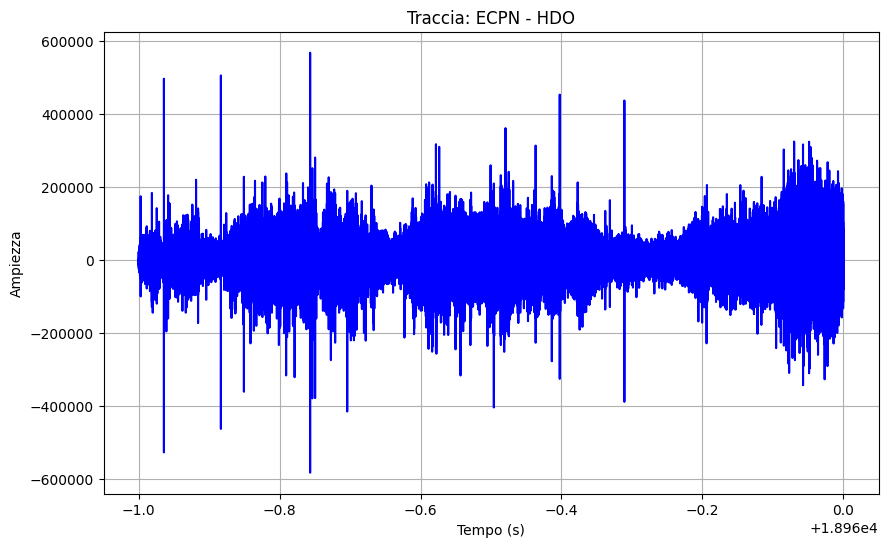

In [16]:
import matplotlib.pyplot as plt
from obspy import read

# Definisci il percorso del file .mseed
mseed_file_path = "E:/data/sismico_infra/ECPN/HDO.D/IT.ECPN..HDO.D.2021.332"  # Sostituisci con il percorso corretto

# Leggi il file mseed usando ObsPy
st = read(mseed_file_path)

# Stampa le informazioni di base del file
print(st)

# Itera su ogni traccia nel file e plottala
for trace in st:
    # Stampa le statistiche della traccia
    print(trace.stats)
    
    # Plotta la traccia
    plt.figure(figsize=(10, 6))
    plt.plot(trace.times("matplotlib"), trace.data, color='b')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Ampiezza')
    plt.title(f'Traccia: {trace.stats.station} - {trace.stats.channel}')
    plt.grid()
    plt.show()


In [2]:
import os
import numpy as np
import pickle
from obspy import read
from scipy.signal import hilbert, find_peaks, decimate, butter, filtfilt
from scipy.fftpack import fft
from scipy.stats import skew, kurtosis
import pywt
import pandas as pd
from datetime import datetime, timedelta
import psutil

# Funzioni di estrazione delle feature
def wavelet_denoise(signal, wavelet='db1', level=1, dynamic_adjustment=False):
    """
    Denoises a signal using wavelet decomposition and thresholding.

    Parameters:
    - signal: The input signal.
    - wavelet: The wavelet type to use.
    - level: The level of decomposition.
    - dynamic_adjustment: If True, adjusts wavelet and level dynamically based on signal length.

    Returns:
    - Denoised signal, distortion.
    """
    if dynamic_adjustment:
        level = min(level, int(np.log2(len(signal))))  # Adjust level to signal length.
        wavelet = 'db' + str(max(1, int(level / 2)))  # Adjust wavelet dynamically.

    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [pywt.threshold(c, uthresh, mode='hard') for c in coeffs]  # Using hard thresholding.
    reconstructed_signal = pywt.waverec(denoised_coeffs, wavelet) if len(denoised_coeffs) > 0 else np.full(len(signal), np.nan)

    # Check for signal distortion
    distortion = None
    if len(signal) == len(reconstructed_signal):
        distortion = np.sum((signal - reconstructed_signal)**2) / np.sum(signal**2)

    return reconstructed_signal, distortion

def apply_bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def calculate_peak_to_peak_amplitude(signal):
    return np.ptp(signal) if len(signal) > 0 else np.nan

def calculate_rms_amplitude(signal):
    if len(signal) == 0:
        return np.nan
    return np.sqrt(np.mean(signal**2))

def calculate_zero_crossing_rate(signal, duration):
    if duration == 0:
        return np.nan
    return ((signal[:-1] * signal[1:]) < 0).sum() / duration

def calculate_rise_time(signal, sampling_rate):
    if sampling_rate <= 0 or len(signal) == 0:
        return np.nan
    envelope = np.abs(hilbert(signal))
    return np.argmax(envelope) / sampling_rate

def calculate_decay_time(signal, sampling_rate):
    if sampling_rate <= 0 or len(signal) == 0:
        return np.nan
    envelope = np.abs(hilbert(signal))
    return (len(signal) - np.argmax(envelope)) / sampling_rate

def calculate_mean_amplitude(signal):
    return np.mean(signal) if len(signal) > 0 else np.nan

def calculate_variance(signal):
    return np.var(signal) if len(signal) > 0 else np.nan

def calculate_skewness(signal):
    return skew(signal) if len(signal) > 1 else np.nan

def calculate_kurtosis(signal):
    return kurtosis(signal) if len(signal) > 1 else np.nan

def calculate_crest_factor(peak_to_peak_amplitude, rms_amplitude):
    return peak_to_peak_amplitude / rms_amplitude if rms_amplitude > 0 else np.nan

def calculate_fft_spectrum(signal, sampling_rate):
    if sampling_rate == 0 or len(signal) == 0:
        return np.array([]), np.array([])
    fft_spectrum = np.abs(fft(signal))
    freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)
    positive_freqs = freqs[freqs >= 0]
    positive_spectrum = fft_spectrum[freqs >= 0]
    return positive_freqs, positive_spectrum

def calculate_dominant_frequency(positive_freqs, positive_spectrum):
    return positive_freqs[np.argmax(positive_spectrum)] if len(positive_spectrum) > 0 else np.nan

def calculate_spectral_centroid(positive_freqs, positive_spectrum):
    if len(positive_spectrum) == 0 or np.isnan(positive_spectrum).any():
        return np.nan
    return (np.sum(positive_freqs * positive_spectrum) / np.sum(positive_spectrum)) if np.sum(positive_spectrum) > 0 else np.nan

def calculate_spectral_bandwidth(positive_freqs, positive_spectrum, spectral_centroid):
    if spectral_centroid == 0 or len(positive_spectrum) == 0 or np.isnan(positive_spectrum).any():
        return np.nan
    return (np.sqrt(np.sum(((positive_freqs - spectral_centroid)**2) * positive_spectrum) / np.sum(positive_spectrum))) if np.sum(positive_spectrum) > 0 else np.nan

def calculate_spectral_entropy(positive_spectrum):
    if len(positive_spectrum) == 0:
        return np.nan
    normalized_spectrum = positive_spectrum / (np.sum(positive_spectrum) + 1e-10)
    return -np.sum(normalized_spectrum * np.log2(normalized_spectrum + 1e-10)) if np.sum(positive_spectrum) > 0 else np.nan

def calculate_spectral_flatness(positive_spectrum):
    if len(positive_spectrum) == 0:
        return np.nan
    normalized_spectrum = positive_spectrum / (np.sum(positive_spectrum) + 1e-10)
    return np.exp(np.mean(np.log(normalized_spectrum + 1e-10))) / np.mean(normalized_spectrum) if np.sum(positive_spectrum) > 0 else np.nan

def calculate_peak_frequency(positive_freqs, positive_spectrum):
    return positive_freqs[np.argmax(positive_spectrum)] if len(positive_spectrum) > 0 else np.nan

def calculate_rolling_snr(signal, window_size=50):
    if len(signal) == 0:
        return np.nan
    signal_power = pd.Series(signal**2).rolling(window=window_size, min_periods=1).mean() + 1e-10
    noise_power = pd.Series((signal - signal.mean())**2).rolling(window=window_size, min_periods=1).mean() + 1e-10
    snr = 10 * np.log10(signal_power / noise_power)
    return np.nanmean(snr) if not np.isnan(snr).all() else np.nan

def extract_infrasound_features(signal, sampling_rate, lowcut=None, highcut=None):
    try:
        if lowcut and highcut:
            signal = apply_bandpass_filter(signal, lowcut, highcut, sampling_rate)
        denoised_signal, distortion = wavelet_denoise(signal, dynamic_adjustment=True)
        features = {
            'Peak-to-Peak Amplitude': calculate_peak_to_peak_amplitude(denoised_signal),
            'RMS Amplitude': calculate_rms_amplitude(denoised_signal),
            'Zero Crossing Rate': calculate_zero_crossing_rate(denoised_signal, len(denoised_signal) / sampling_rate),
            'Rise Time': calculate_rise_time(denoised_signal, sampling_rate),
            'Decay Time': calculate_decay_time(denoised_signal, sampling_rate),
            'Mean Amplitude': calculate_mean_amplitude(denoised_signal),
            'Variance': calculate_variance(denoised_signal),
            'Skewness': calculate_skewness(denoised_signal),
            'Kurtosis': calculate_kurtosis(denoised_signal),
            'Crest Factor': calculate_crest_factor(
                calculate_peak_to_peak_amplitude(denoised_signal), calculate_rms_amplitude(denoised_signal)
            ),
            'Rolling SNR': calculate_rolling_snr(denoised_signal),
            'Distortion': distortion
        }
        positive_freqs, positive_spectrum = calculate_fft_spectrum(denoised_signal, sampling_rate)
        spectral_centroid = calculate_spectral_centroid(positive_freqs, positive_spectrum)
        spectral_bandwidth = calculate_spectral_bandwidth(positive_freqs, positive_spectrum, spectral_centroid)
        features.update({
            'Dominant Frequency': calculate_dominant_frequency(positive_freqs, positive_spectrum),
            'Spectral Centroid': spectral_centroid,
            'Spectral Bandwidth': spectral_bandwidth,
            'Spectral Entropy': calculate_spectral_entropy(positive_spectrum),
            'Spectral Flatness': calculate_spectral_flatness(positive_spectrum),
            'Peak Frequency': calculate_peak_frequency(positive_freqs, positive_spectrum),
        })
    except Exception as e:
        print(f"Error extracting features: {e}")
        features = {key: np.nan for key in [
            'Peak-to-Peak Amplitude', 'RMS Amplitude', 'Zero Crossing Rate', 'Rise Time', 'Decay Time',
            'Mean Amplitude', 'Variance', 'Skewness', 'Kurtosis', 'Crest Factor', 'Rolling SNR', 'Distortion',
            'Dominant Frequency', 'Spectral Centroid', 'Spectral Bandwidth', 'Spectral Entropy', 'Spectral Flatness', 'Peak Frequency'
        ]}
    return features

def process_file(file_path, sampling_rate, station, component, output_dir, lowcut=None, highcut=None):
    station_features = []
    distortion_exceed_count = 0
    total_segments = 0
    try:
        st = read(file_path)
        for tr in st:
            signal = tr.data
            sampling_rate = tr.stats.sampling_rate
            starttime = tr.stats.starttime

            if len(signal) == 0 or sampling_rate == 0:
                continue

            n_samples_per_minute = int(sampling_rate * 60)
            for i in range(0, len(signal), n_samples_per_minute):
                minute_signal = signal[i:i + n_samples_per_minute]
                timestamp = starttime + timedelta(seconds=i / sampling_rate)

                if len(minute_signal) < n_samples_per_minute or np.all(minute_signal == 0) or np.isnan(minute_signal).any():
                    continue

                features = extract_infrasound_features(minute_signal, sampling_rate, lowcut, highcut)
                features['Timestamp'] = str(timestamp)  # Add the timestamp to the features
                station_features.append(features)

                if features['Distortion'] is not None and features['Distortion'] > 0.1:
                    distortion_exceed_count += 1
                total_segments += 1
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

    if total_segments > 0:
        distortion_percentage = (distortion_exceed_count / total_segments) * 100
        print(f"File {file_path}: {distortion_percentage:.2f}% of segments exceed distortion threshold.")

    return station_features

def process_infrasound_data(data_dir, stations, components, output_dir, sampling_rate=50, lowcut=None, highcut=None):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_timestamps = pd.date_range(start="2021-01-01", end="2021-12-31 23:59:59", freq="1min")
    timestamp_df = pd.DataFrame({'Timestamp': all_timestamps})
    timestamp_df['Timestamp'] = pd.to_datetime(timestamp_df['Timestamp']).dt.tz_localize(None)

    for station in stations:
        station_path = os.path.join(data_dir, station)
        station_features_map = []

        for component in components:
            component_path = os.path.join(station_path, component)
            if os.path.isdir(component_path):
                files = [os.path.join(component_path, file_name) for file_name in os.listdir(component_path)]
                for file_path in files:
                    print(f"Processing file {file_path} for station {station}, component {component}.")
                    result = process_file(file_path, sampling_rate, station, component, output_dir, lowcut, highcut)
                    if result:
                        station_features_map.extend(result)

        # Merge station features with the full timestamp range
        station_features = pd.DataFrame(station_features_map)
        if not station_features.empty:
            station_features['Timestamp'] = pd.to_datetime(station_features['Timestamp']).dt.tz_localize(None)
        merged_features = pd.merge(timestamp_df, station_features, on='Timestamp', how='left')

        # Save the merged features immediately
        output_file = os.path.join(output_dir, f"{station}_features.pkl")
        merged_features.to_pickle(output_file)
        print(f"Features for station {station} saved to {output_file}")

if __name__ == "__main__":
    # Esempio di utilizzo
    data_dir = "E:\data\sismico_infra"
    output_dir = "output/infrasonic"
    stations = ["ECPN", "ESLN", "EPDN", "ECNE"]
    components = ['HDO.D']
    lowcut = 0.1 
    highcut = 10.0 

    process_infrasound_data(data_dir, stations, components, output_dir, lowcut=lowcut, highcut=highcut)

Processing file E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.001 for station ECPN, component HDO.D.
File E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.001: 0.00% of segments exceed distortion threshold.
Processing file E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.002 for station ECPN, component HDO.D.
File E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.002: 0.00% of segments exceed distortion threshold.
Processing file E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.003 for station ECPN, component HDO.D.
File E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.003: 0.00% of segments exceed distortion threshold.
Processing file E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.004 for station ECPN, component HDO.D.
File E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.004: 0.00% of segments exceed distortion threshold.
Processing file E:\data\sismico_infra\ECPN\HDO.D\IT.ECPN..HDO.D.2021.005 for station ECPN, component HDO.D.
File E:\data\sismico

In [3]:
import os
import pandas as pd

def view_station_pkl_files(output_dir):
    """
    Funzione per aprire e visualizzare le prime 10 righe dei file .pkl per ogni stazione.

    Parameters:
    output_dir (str): Directory contenente i file .pkl delle stazioni.
    """
    try:
        # Lista dei file nella directory
        files = [f for f in os.listdir(output_dir) if f.endswith("_features.pkl")]
        if not files:
            print("Nessun file finale trovato nella directory fornita.")
            return

        for file_name in files:
            file_path = os.path.join(output_dir, file_name)
            print(f"Visualizzando le prime 10 righe del file: {file_name}")
            try:
                # Carica il file .pkl in un DataFrame
                data = pd.read_pickle(file_path)
                # Visualizza le prime 10 righe
                print(data.head(1000000))
            except Exception as e:
                print(f"Errore durante l'apertura del file {file_name}: {e}")
    except Exception as e:
        print(f"Errore durante l'accesso alla directory {output_dir}: {e}")

if __name__ == "__main__":
    # Esempio di utilizzo
    output_dir = "output/infrasonic"  # Sostituisci con il percorso della directory di output
    view_station_pkl_files(output_dir)

Visualizzando le prime 10 righe del file: ECNE_features.pkl
                 Timestamp  Peak-to-Peak Amplitude  RMS Amplitude  \
0      2021-01-01 00:00:00              416.532748      72.617667   
1      2021-01-01 00:01:00              522.261244      73.355059   
2      2021-01-01 00:02:00              322.428398      62.276944   
3      2021-01-01 00:03:00              771.268665      87.830817   
4      2021-01-01 00:04:00              680.488185      96.535000   
...                    ...                     ...            ...   
525595 2021-12-31 23:55:00              243.417532      30.324112   
525596 2021-12-31 23:56:00              286.982736      31.008207   
525597 2021-12-31 23:57:00              139.369807      23.357242   
525598 2021-12-31 23:58:00              116.932899      22.566929   
525599 2021-12-31 23:59:00              327.444762      45.915184   

        Zero Crossing Rate  Rise Time  Decay Time  Mean Amplitude  \
0                 0.050000      46.52     

In [1]:
import pandas as pd
import os

# Specifica la directory dei file
data_directory = 'output/infrasonic/'

# Carica i file
epdn_features = pd.read_pickle(os.path.join(data_directory, 'EPDN_features.pkl'))
ecpn_features = pd.read_pickle(os.path.join(data_directory, 'ECPN_features.pkl'))
esln_features = pd.read_pickle(os.path.join(data_directory, 'ESLN_features.pkl'))
ecne_features = pd.read_pickle(os.path.join(data_directory, 'ECNE_features.pkl'))

# Lista delle feature da analizzare
features_to_check = [
    'Peak-to-Peak Amplitude', 'RMS Amplitude', 'Zero Crossing Rate', 'Rise Time', 'Decay Time', 
    'Mean Amplitude', 'Variance', 'Skewness', 'Kurtosis', 'Crest Factor', 
    'Dominant Frequency', 'Spectral Centroid', 'Spectral Bandwidth', 
    'Spectral Entropy', 'Spectral Flatness', 'Peak Frequency', 'Rolling SNR'
]

# Funzione per analizzare tutti i gap distinti di NaN e 0 con durata superiore a 5 minuti
def analyze_combined_gaps(df, station_name, base_timestamp):
    results = []
    for feature in features_to_check:
        if feature in df.columns:
            # Maschera per valori NaN o pari a 0
            combined_mask = df[feature].isna() | (df[feature] == 0)
            
            # Trova i gruppi consecutivi di True (gap)
            gaps = (combined_mask != combined_mask.shift()).cumsum()  # Identifica i gruppi
            gap_groups = combined_mask.groupby(gaps)
            
            for group, indices in gap_groups:
                if combined_mask[indices.index[0]]:  # Se il gruppo è un gap (True)
                    gap_start = indices.index[0]
                    gap_end = indices.index[-1]
                    
                    # Calcola la durata del gap in minuti
                    gap_duration = gap_end - gap_start + 1  # +1 per includere entrambi gli estremi
                    
                    # Considera solo gap con durata > 5 minuti
                    if gap_duration > 100:
                        results.append({
                            "Station": station_name,
                            "Feature": feature,
                            "Gap_Start_Time": base_timestamp + pd.to_timedelta(gap_start, unit='m'),
                            "Gap_End_Time": base_timestamp + pd.to_timedelta(gap_end, unit='m'),
                            "Gap_Duration_Minutes": gap_duration
                        })
    return results


# Definisci il timestamp iniziale
base_timestamp = pd.Timestamp("2021-01-01 00:00:00")

# Analizza tutti i file
all_results = []
all_results.extend(analyze_combined_gaps(epdn_features, "EPDN", base_timestamp))
all_results.extend(analyze_combined_gaps(ecpn_features, "ECPN", base_timestamp))
all_results.extend(analyze_combined_gaps(esln_features, "ESLN", base_timestamp))
all_results.extend(analyze_combined_gaps(ecne_features, "ECNE", base_timestamp))

# Crea un DataFrame con i risultati
results_df = pd.DataFrame(all_results)

# Mostra i risultati
print(results_df)

# Salva i risultati in un file CSV (opzionale)
results_df.to_csv('output/infrasonic/combined_gap_analysis_with_timestamps.csv', index=False)

    Station                 Feature      Gap_Start_Time        Gap_End_Time  \
0      EPDN  Peak-to-Peak Amplitude 2021-01-07 14:33:00 2021-05-12 10:00:00   
1      EPDN  Peak-to-Peak Amplitude 2021-05-18 22:07:00 2021-05-26 11:09:00   
2      EPDN  Peak-to-Peak Amplitude 2021-06-24 16:00:00 2021-06-25 03:08:00   
3      EPDN  Peak-to-Peak Amplitude 2021-08-12 15:14:00 2021-08-14 03:56:00   
4      EPDN  Peak-to-Peak Amplitude 2021-11-30 19:01:00 2021-12-02 11:04:00   
..      ...                     ...                 ...                 ...   
862    ECNE             Rolling SNR 2021-11-29 14:08:00 2021-12-02 10:07:00   
863    ECNE             Rolling SNR 2021-12-04 03:43:00 2021-12-04 11:29:00   
864    ECNE             Rolling SNR 2021-12-05 04:35:00 2021-12-05 06:23:00   
865    ECNE             Rolling SNR 2021-12-07 23:59:00 2021-12-08 11:35:00   
866    ECNE             Rolling SNR 2021-12-08 20:18:00 2021-12-15 11:01:00   

     Gap_Duration_Minutes  
0                  1797

Caricamento e plot della feature 'Peak-to-Peak Amplitude' in corso...
Numero di punti dati per la feature 'Peak-to-Peak Amplitude' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Peak-to-Peak Amplitude' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Peak-to-Peak Amplitude' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Peak-to-Peak Amplitude' nella stazione 'ESLN' nel periodo selezionato: 241


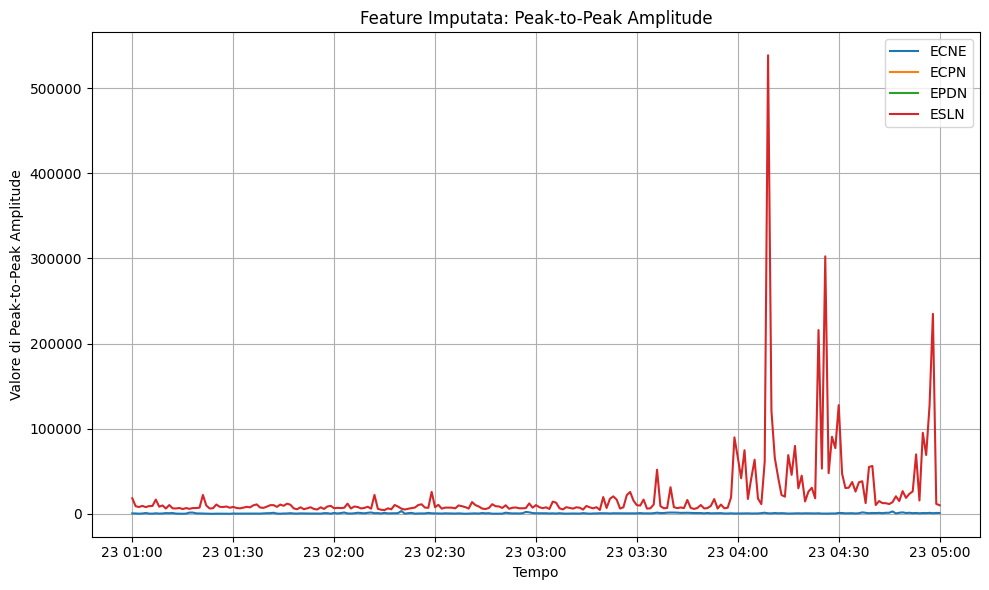

Caricamento e plot della feature 'RMS Amplitude' in corso...
Numero di punti dati per la feature 'RMS Amplitude' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'RMS Amplitude' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'RMS Amplitude' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'RMS Amplitude' nella stazione 'ESLN' nel periodo selezionato: 241


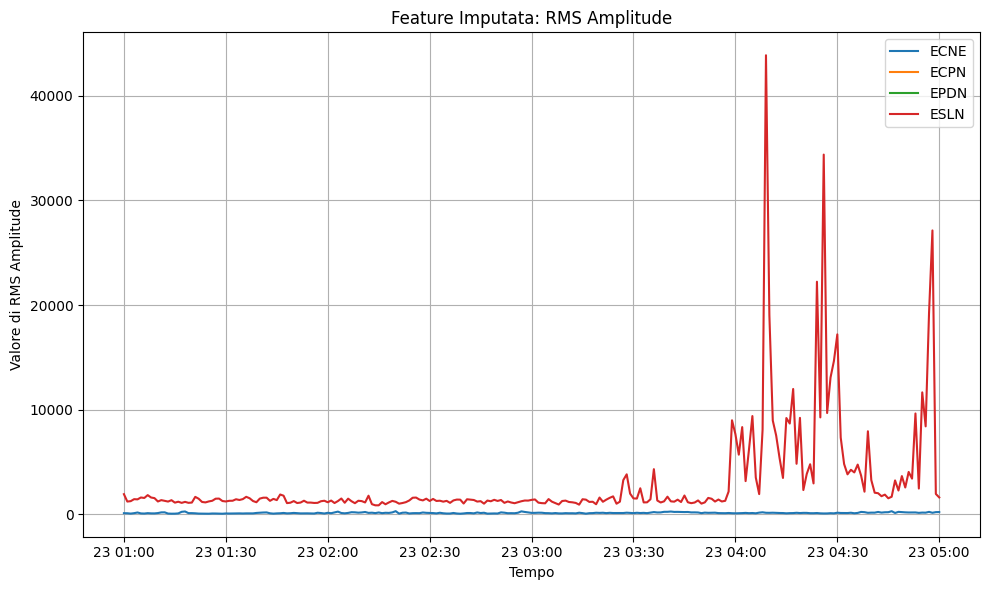

Caricamento e plot della feature 'Zero Crossing Rate' in corso...
Numero di punti dati per la feature 'Zero Crossing Rate' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Zero Crossing Rate' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Zero Crossing Rate' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Zero Crossing Rate' nella stazione 'ESLN' nel periodo selezionato: 241


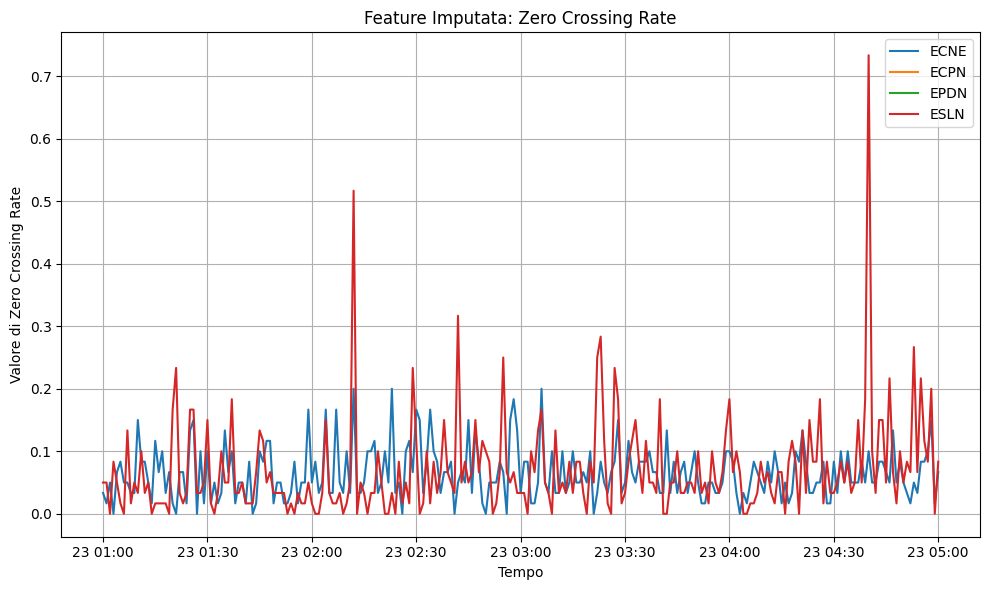

Caricamento e plot della feature 'Rise Time' in corso...
Numero di punti dati per la feature 'Rise Time' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Rise Time' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Rise Time' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Rise Time' nella stazione 'ESLN' nel periodo selezionato: 241


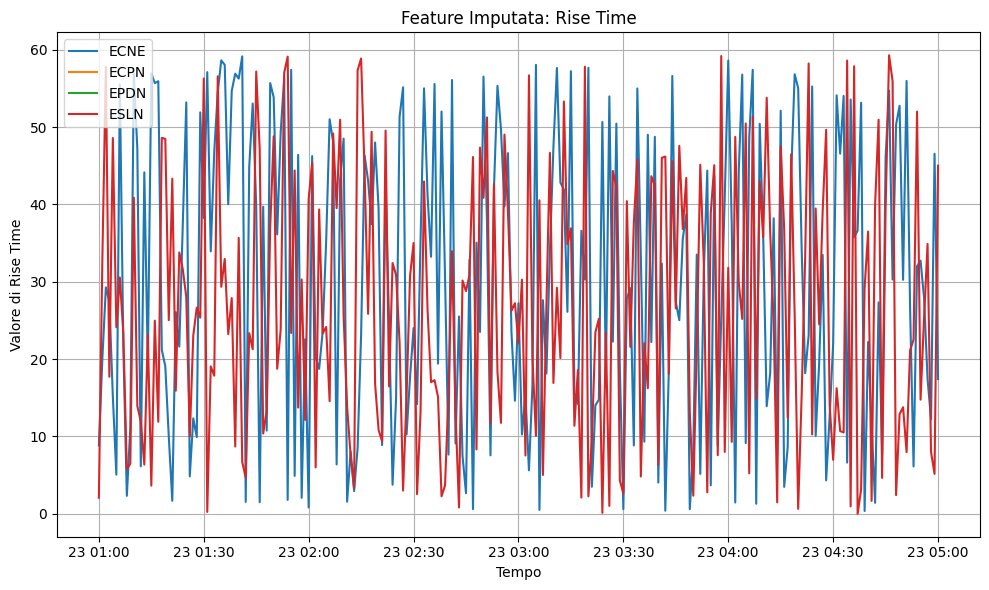

Caricamento e plot della feature 'Decay Time' in corso...
Numero di punti dati per la feature 'Decay Time' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Decay Time' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Decay Time' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Decay Time' nella stazione 'ESLN' nel periodo selezionato: 241


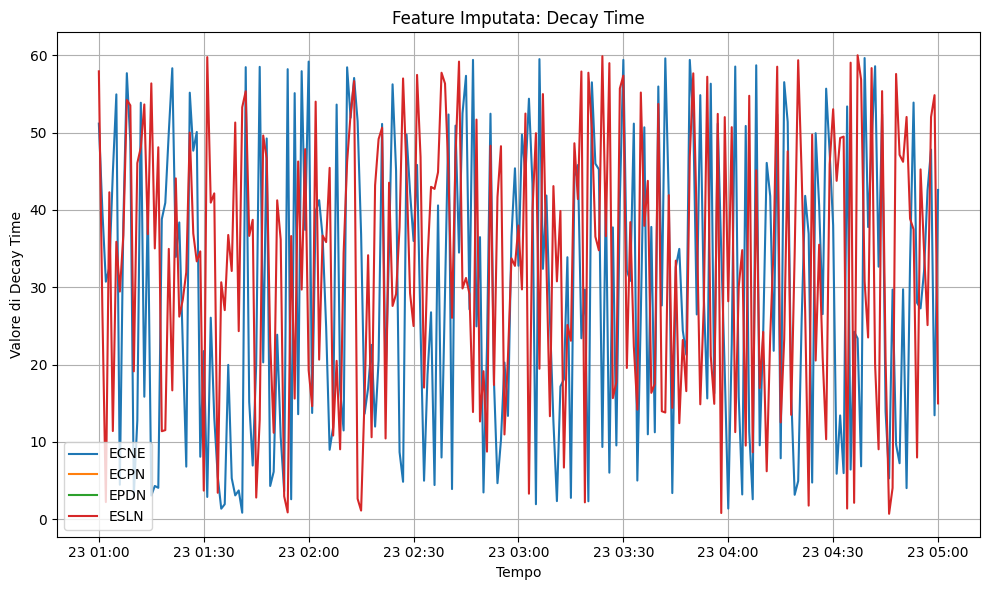

Caricamento e plot della feature 'Mean Amplitude' in corso...
Numero di punti dati per la feature 'Mean Amplitude' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Mean Amplitude' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Mean Amplitude' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Mean Amplitude' nella stazione 'ESLN' nel periodo selezionato: 241


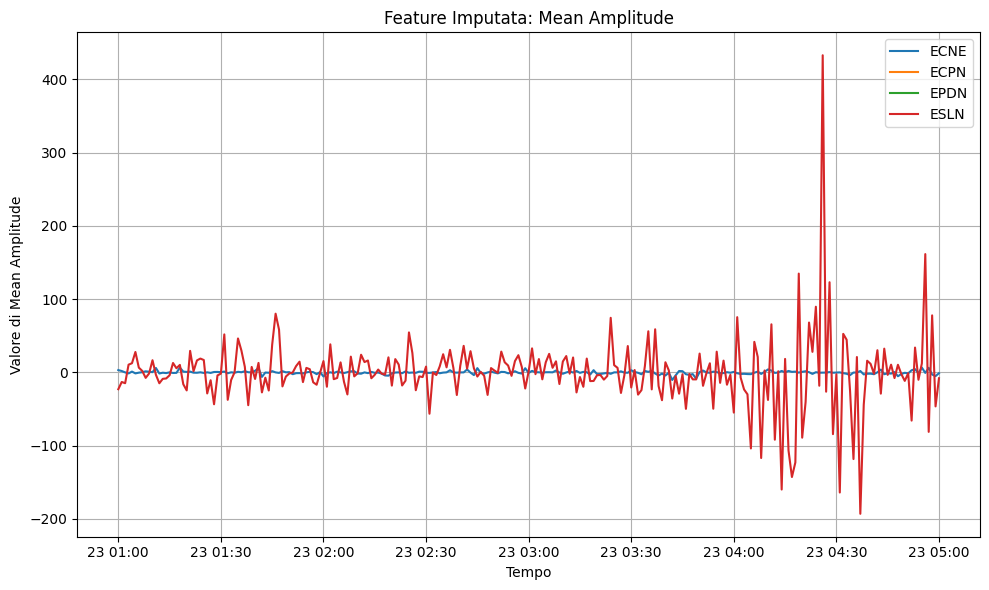

Caricamento e plot della feature 'Variance' in corso...
Numero di punti dati per la feature 'Variance' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Variance' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Variance' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Variance' nella stazione 'ESLN' nel periodo selezionato: 241


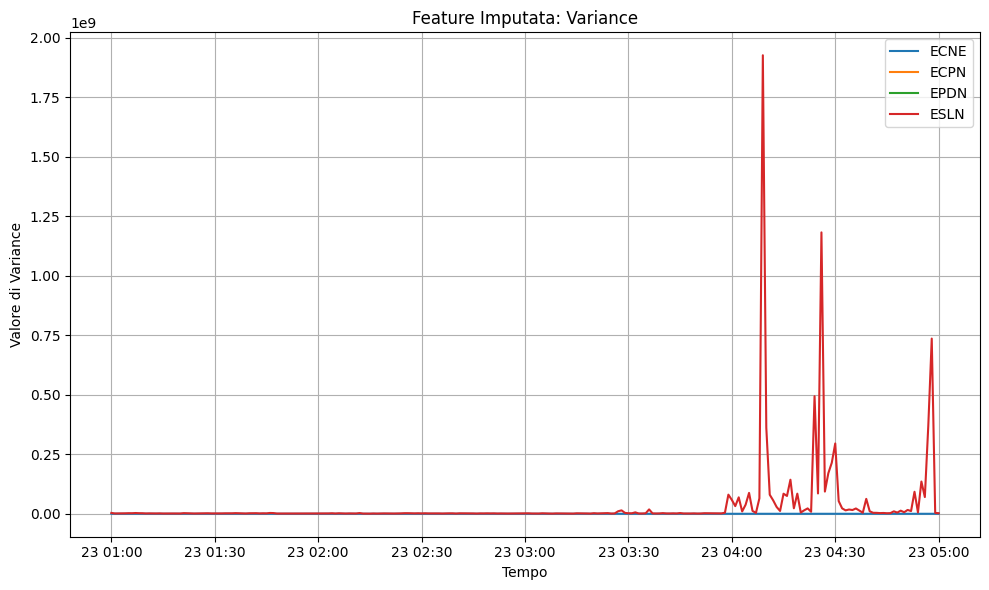

Caricamento e plot della feature 'Skewness' in corso...
Numero di punti dati per la feature 'Skewness' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Skewness' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Skewness' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Skewness' nella stazione 'ESLN' nel periodo selezionato: 241


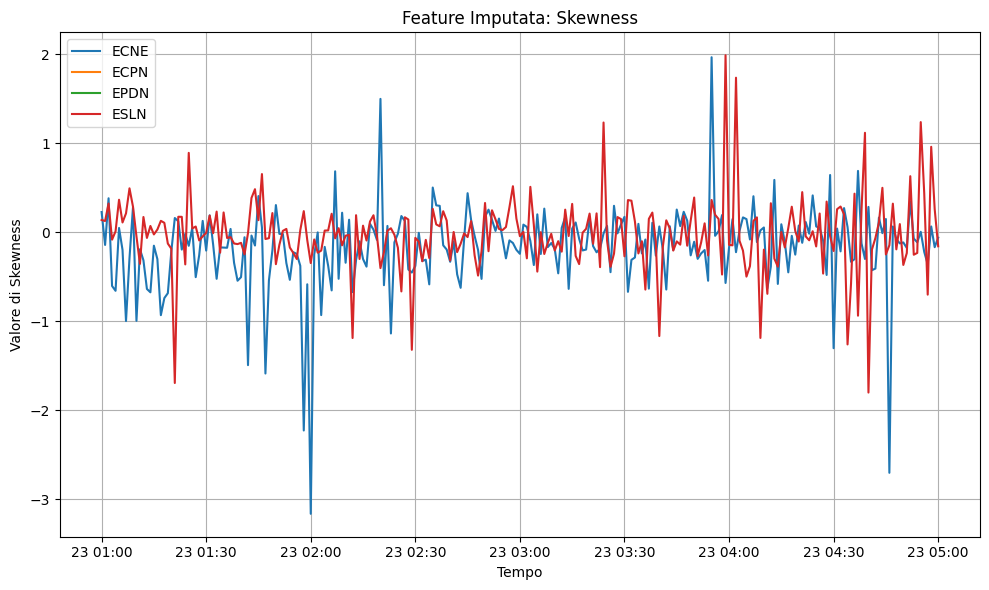

Caricamento e plot della feature 'Kurtosis' in corso...
Numero di punti dati per la feature 'Kurtosis' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Kurtosis' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Kurtosis' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Kurtosis' nella stazione 'ESLN' nel periodo selezionato: 241


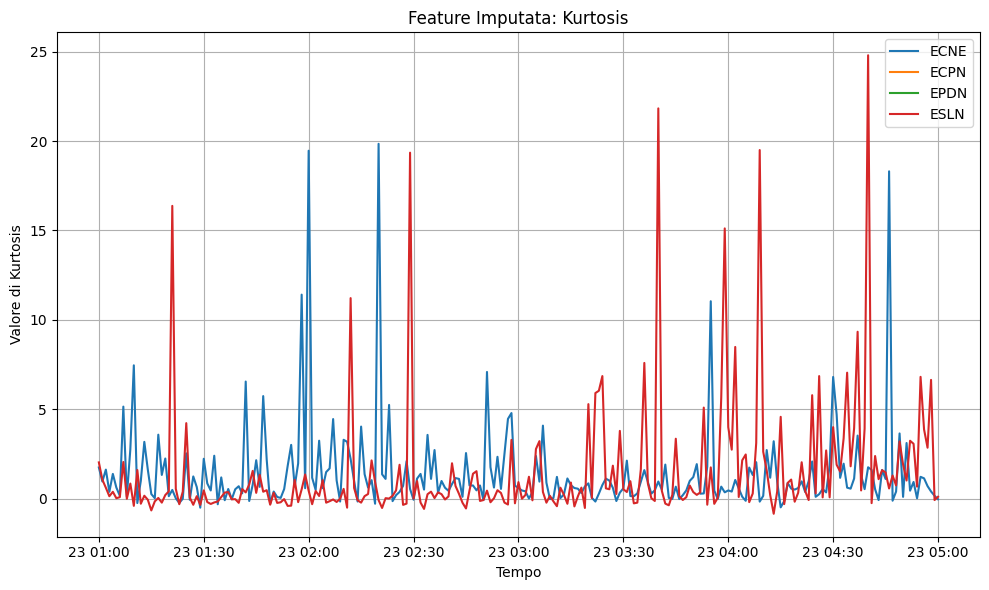

Caricamento e plot della feature 'Crest Factor' in corso...
Numero di punti dati per la feature 'Crest Factor' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Crest Factor' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Crest Factor' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Crest Factor' nella stazione 'ESLN' nel periodo selezionato: 241


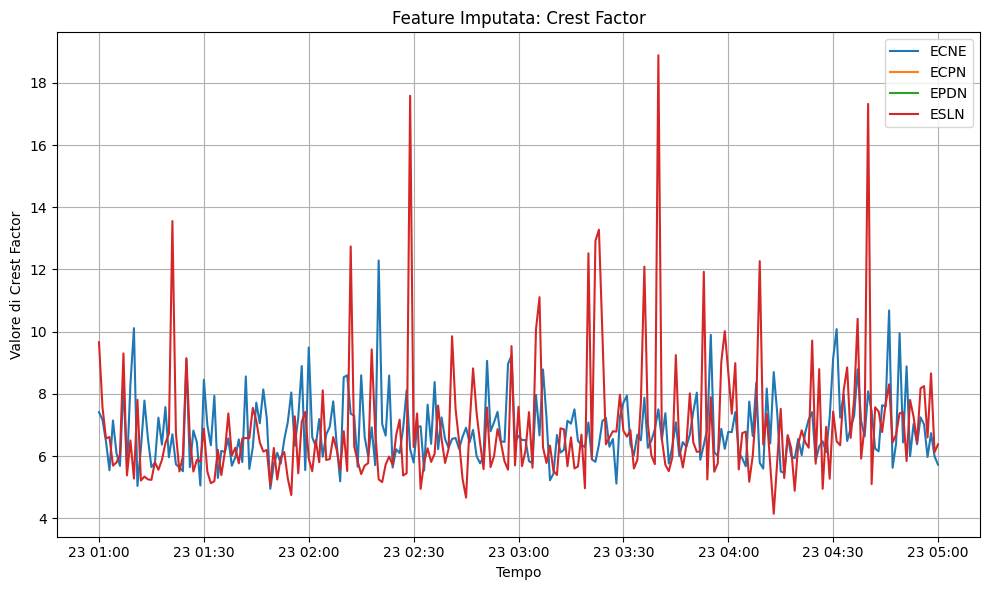

Caricamento e plot della feature 'Dominant Frequency' in corso...
Numero di punti dati per la feature 'Dominant Frequency' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Dominant Frequency' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Dominant Frequency' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Dominant Frequency' nella stazione 'ESLN' nel periodo selezionato: 241


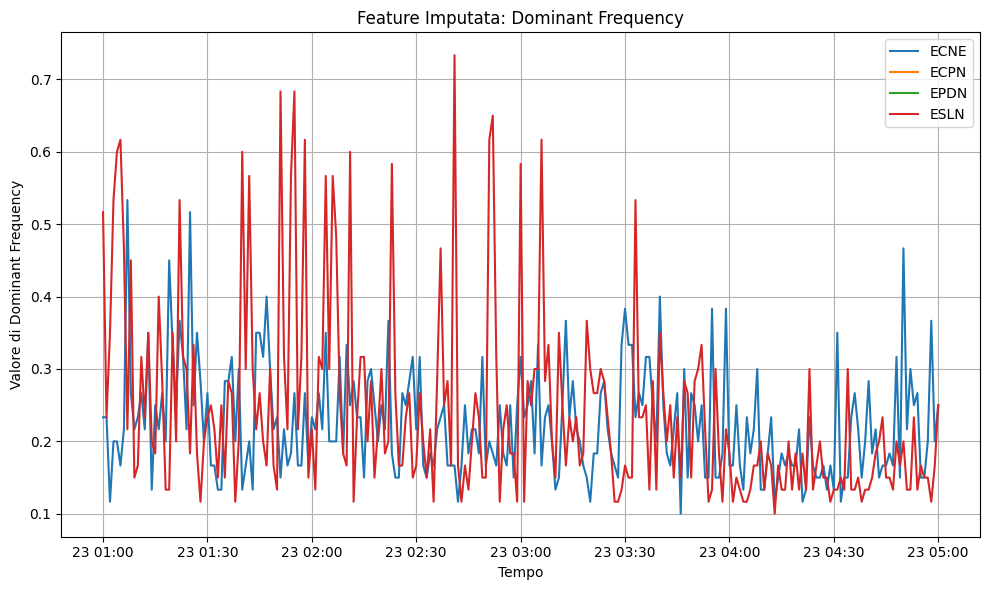

Caricamento e plot della feature 'Spectral Centroid' in corso...
Numero di punti dati per la feature 'Spectral Centroid' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Centroid' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Centroid' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Centroid' nella stazione 'ESLN' nel periodo selezionato: 241


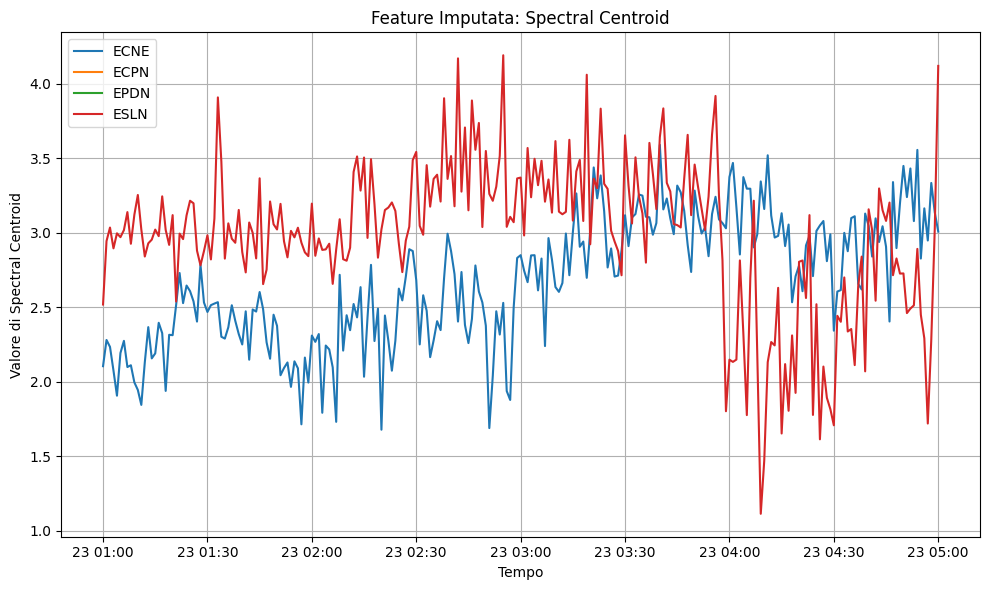

Caricamento e plot della feature 'Spectral Bandwidth' in corso...
Numero di punti dati per la feature 'Spectral Bandwidth' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Bandwidth' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Bandwidth' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Bandwidth' nella stazione 'ESLN' nel periodo selezionato: 241


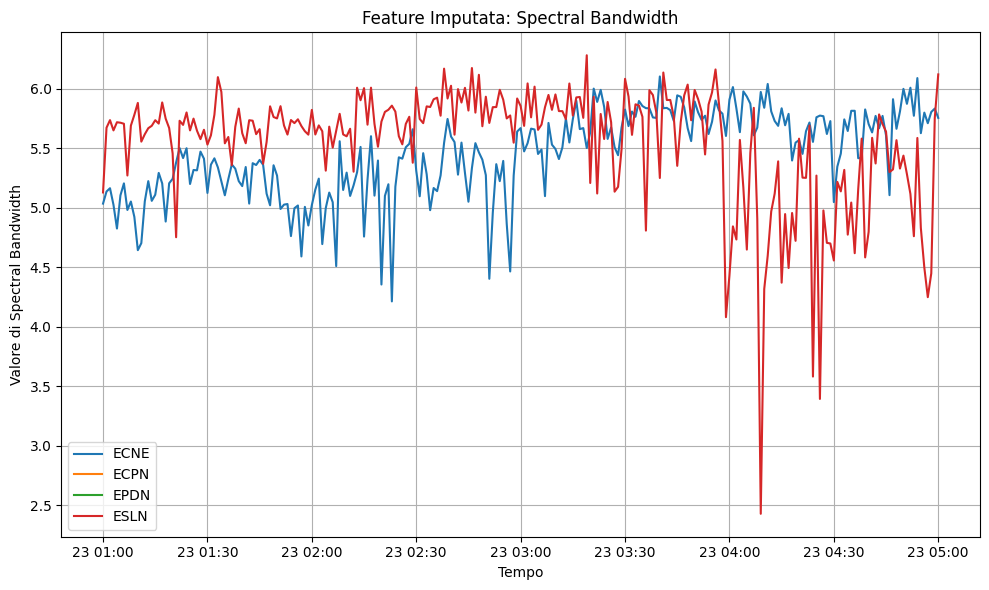

Caricamento e plot della feature 'Spectral Entropy' in corso...
Numero di punti dati per la feature 'Spectral Entropy' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Entropy' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Entropy' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Entropy' nella stazione 'ESLN' nel periodo selezionato: 241


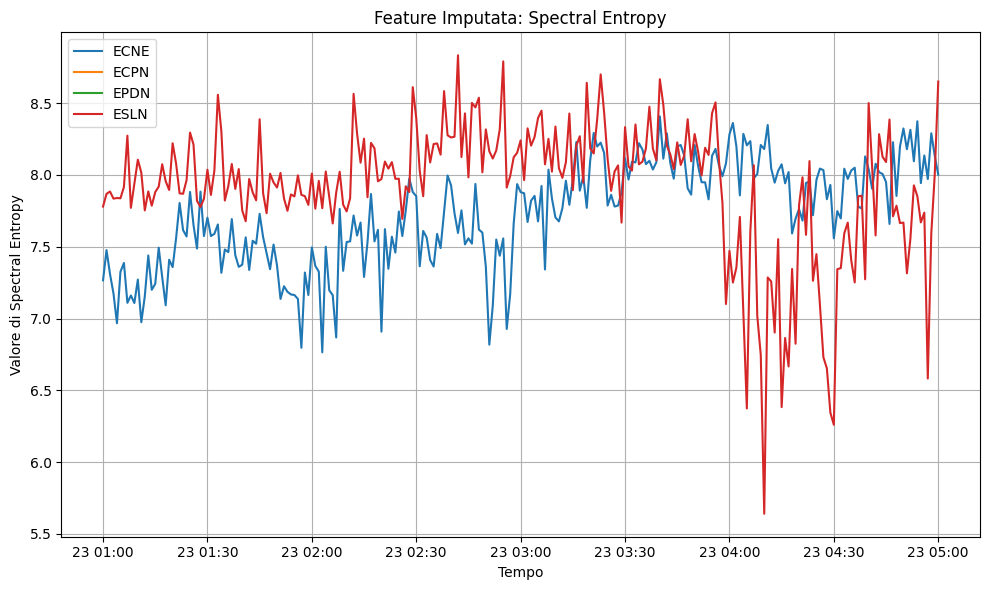

Caricamento e plot della feature 'Spectral Flatness' in corso...
Numero di punti dati per la feature 'Spectral Flatness' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Flatness' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Flatness' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Spectral Flatness' nella stazione 'ESLN' nel periodo selezionato: 241


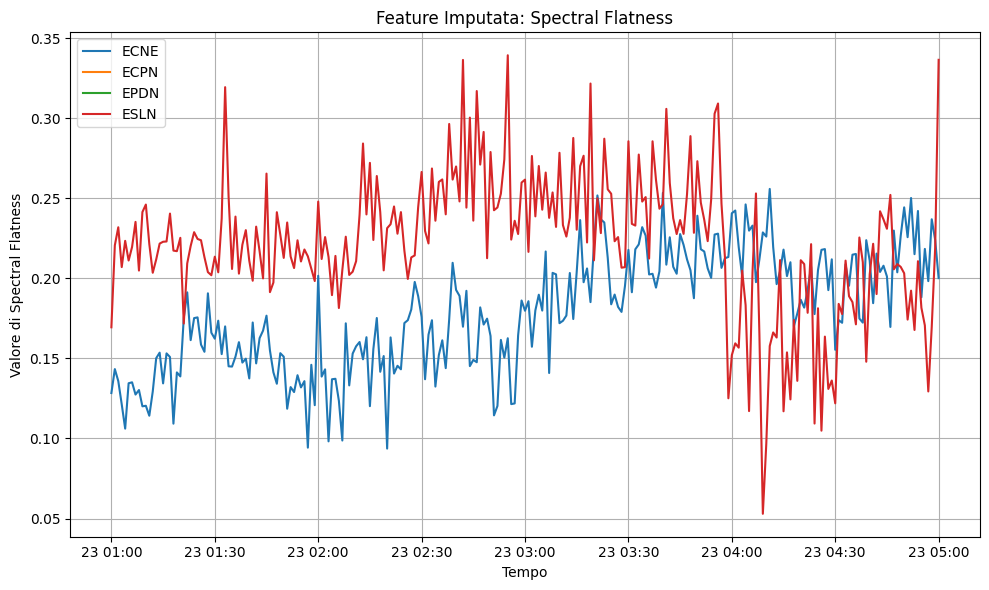

Caricamento e plot della feature 'Peak Frequency' in corso...
Numero di punti dati per la feature 'Peak Frequency' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Peak Frequency' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Peak Frequency' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Peak Frequency' nella stazione 'ESLN' nel periodo selezionato: 241


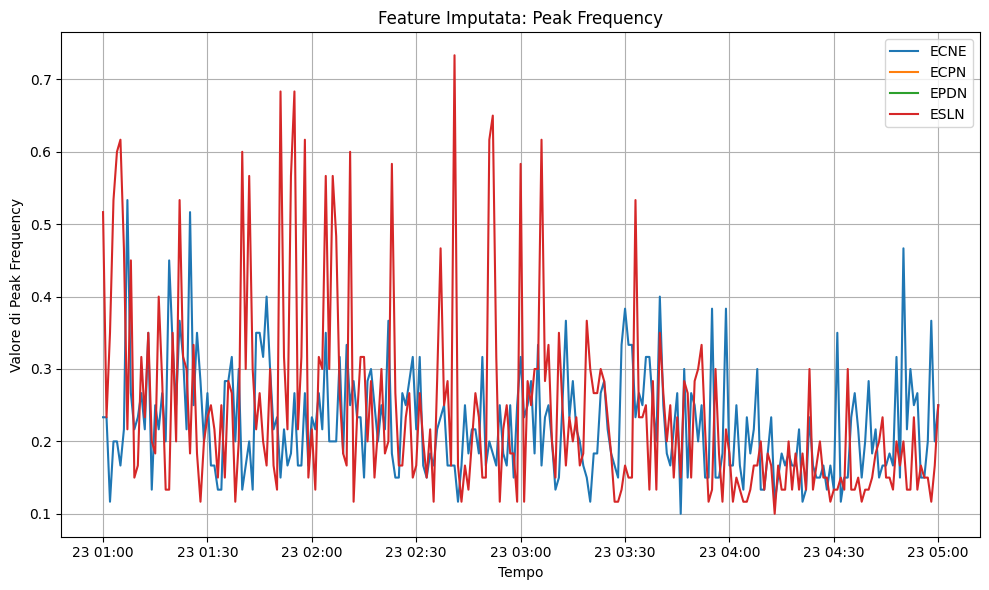

Caricamento e plot della feature 'Rolling SNR' in corso...
Numero di punti dati per la feature 'Rolling SNR' nella stazione 'ECNE' nel periodo selezionato: 241
Numero di punti dati per la feature 'Rolling SNR' nella stazione 'ECPN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Rolling SNR' nella stazione 'EPDN' nel periodo selezionato: 241
Numero di punti dati per la feature 'Rolling SNR' nella stazione 'ESLN' nel periodo selezionato: 241


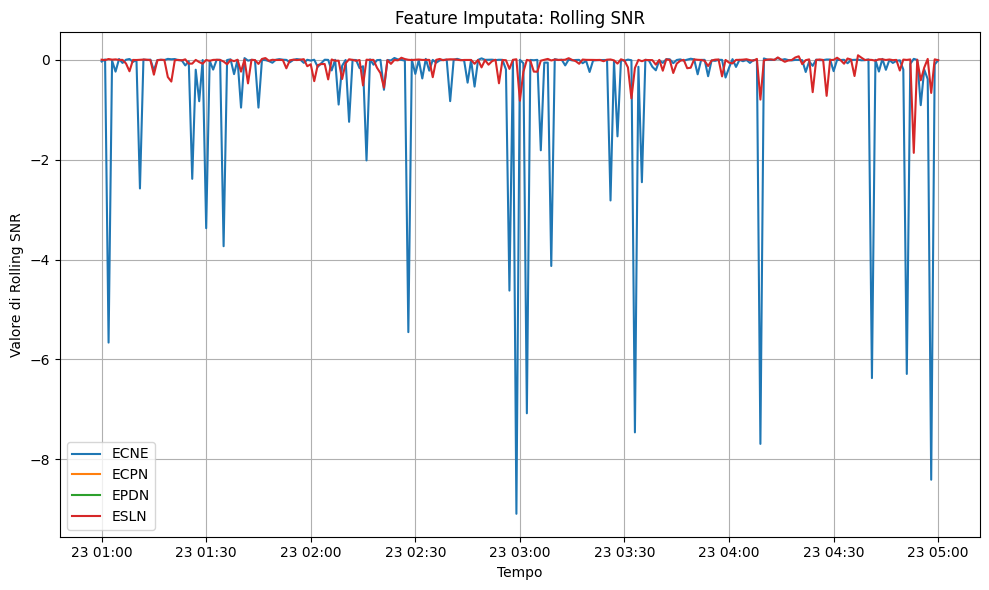

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os

station_dirs = {
    'ECNE': 'output/infrasonic/ECNE_features.pkl',
    'ECPN': 'output/infrasonic/ECPN_features.pkl',
    'EPDN': 'output/infrasonic/EPDN_features.pkl',
    'ESLN': 'output/infrasonic/ESLN_features.pkl'
}

# Lista delle feature da elaborare
features = ['Peak-to-Peak Amplitude', 'RMS Amplitude', 'Zero Crossing Rate', 'Rise Time', 'Decay Time', 'Mean Amplitude',
            'Variance', 'Skewness', 'Kurtosis', 'Crest Factor',
            'Dominant Frequency', 'Spectral Centroid', 'Spectral Bandwidth',
            'Spectral Entropy', 'Spectral Flatness', 'Peak Frequency', 'Rolling SNR']

# Funzione per caricare i dati imputati
def load_imputed_feature_data(feature_name, station_dirs):
    feature_data = {}
    for station, feature_file in station_dirs.items():
        if os.path.exists(feature_file):
            with open(feature_file, 'rb') as f:
                data = pickle.load(f)
                if feature_name in data.columns:
                    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
                    data.set_index('Timestamp', inplace=True)
                    feature_data[station] = data[[feature_name]]
                else:
                    print(f"Feature '{feature_name}' not found in file for station '{station}'")
        else:
            print(f"File not found for station '{station}'")
    return feature_data

# Funzione per plottare i dati in un arco temporale specifico
# Funzione per plottare i dati in un arco temporale specifico
def plot_imputed_features(features, station_dirs):
    # Plottaggio dei dati imputati in un arco temporale specificato
    start_time = '2021-3-23 01:00:00'
    end_time = '2021-3-23 5:00:00'
    start_time = pd.to_datetime(start_time).tz_localize('UTC')  # Ensure timezone-aware
    end_time = pd.to_datetime(end_time).tz_localize('UTC')      # Ensure timezone-aware
    
    for feature in features:
        print(f"Caricamento e plot della feature '{feature}' in corso...")
        feature_data = load_imputed_feature_data(feature, station_dirs)
        plt.figure(figsize=(10, 6))

        for station, data in feature_data.items():
            # Ensure data index is timezone-aware
            if data.index.tz is None:
                data.index = data.index.tz_localize('UTC')
                
            # Filtraggio delle date
            try:
                filtered_data = data[(data.index >= start_time) & (data.index <= end_time)]
            except KeyError as e:
                print(f"Errore nel filtraggio dei dati per la stazione '{station}': {e}")
                continue
            
            # Controllo quanti dati sono stati selezionati per il periodo scelto
            if filtered_data.empty:
                print(f"Nessun dato disponibile per la feature '{feature}' nella stazione '{station}' nel periodo selezionato.")
            else:
                print(f"Numero di punti dati per la feature '{feature}' nella stazione '{station}' nel periodo selezionato: {len(filtered_data)}")
                plt.plot(filtered_data.index, filtered_data[feature], label=station)

        plt.title(f"Feature Imputata: {feature}")
        plt.xlabel("Tempo")
        plt.ylabel(f"Valore di {feature}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_imputed_features(features, station_dirs)



Loaded features for station ECPN
Loaded features for station ESLN
Loaded features for station EPDN
Loaded features for station ECNE

Checking features consistency
  Timestamp: datetime feature, skipping statistical analysis.
  Peak-to-Peak Amplitude: mean=83375.9342, std=207755.7354, min=2.0743, max=10307479.8729


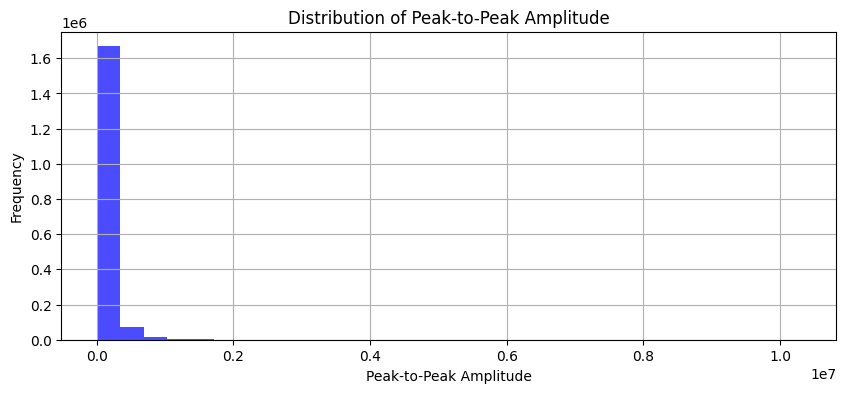

  RMS Amplitude: mean=10207.9401, std=20927.9886, min=0.1485, max=1319363.7739


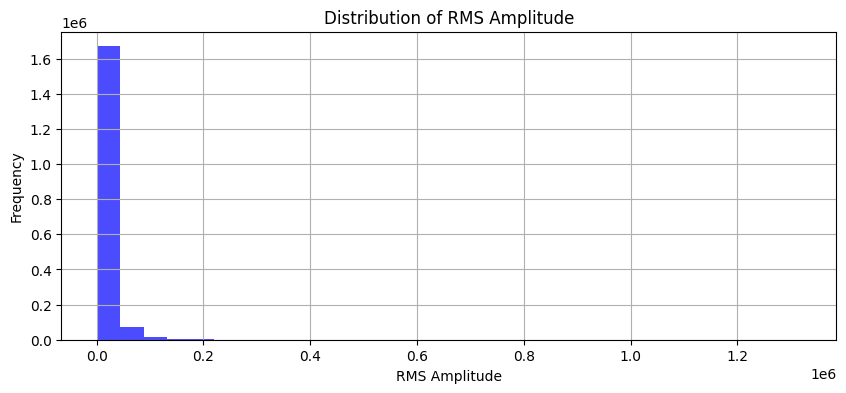

  Zero Crossing Rate: mean=0.1285, std=0.1219, min=0.0000, max=3.7500


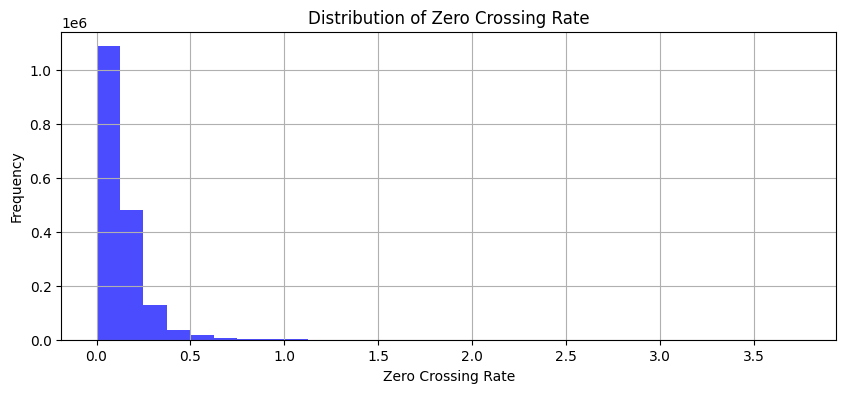

  Rise Time: mean=29.0203, std=18.3249, min=0.0000, max=59.9800


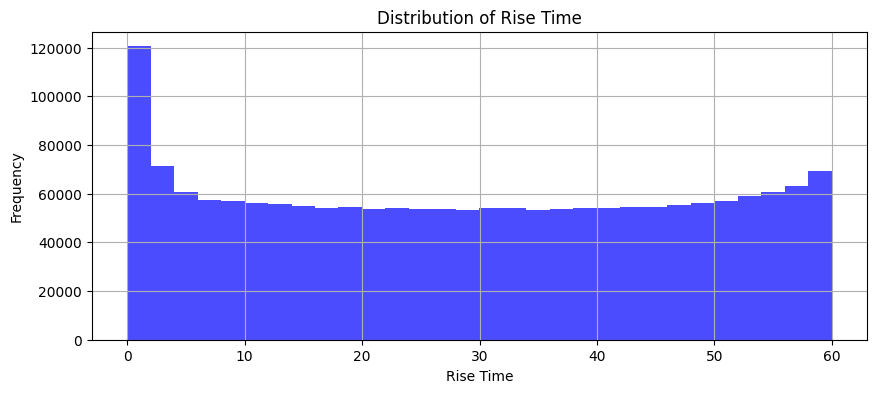

  Decay Time: mean=30.9797, std=18.3249, min=0.0200, max=60.0000


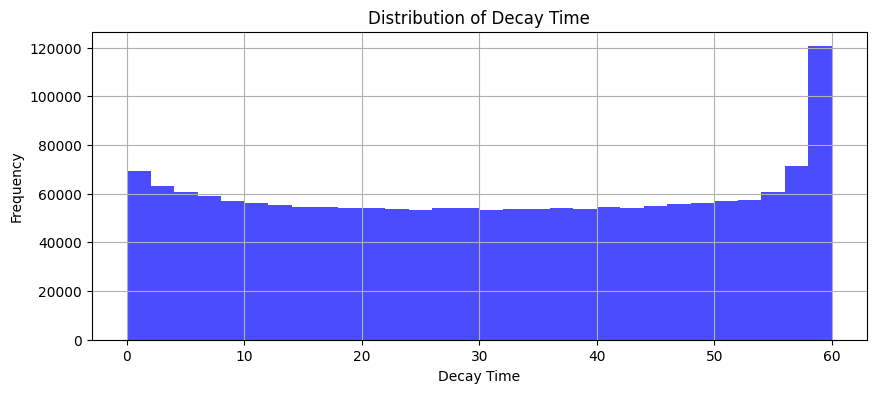

  Mean Amplitude: mean=-6.6792, std=433.7038, min=-46050.8355, max=40603.8510


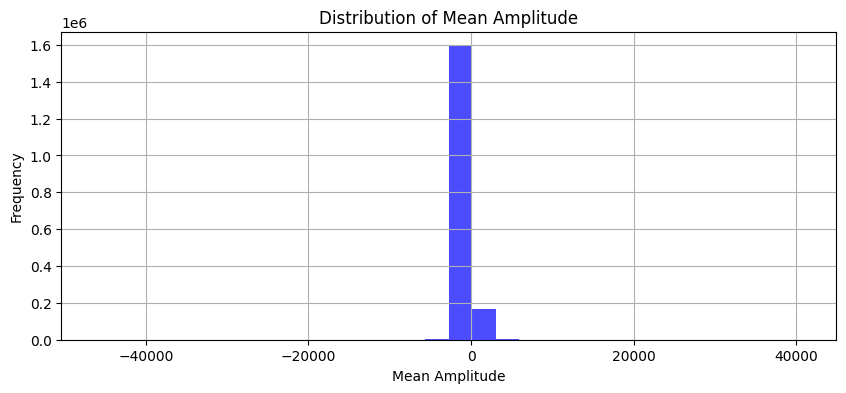

  Variance: mean=541994355.8755, std=5908273579.9605, min=0.0220, max=1740661910221.6606


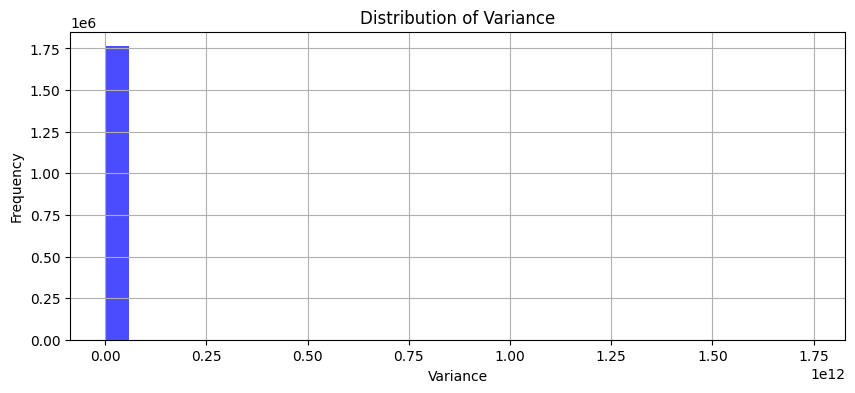

  Skewness: mean=0.0358, std=1.1406, min=-17.8713, max=28.4592


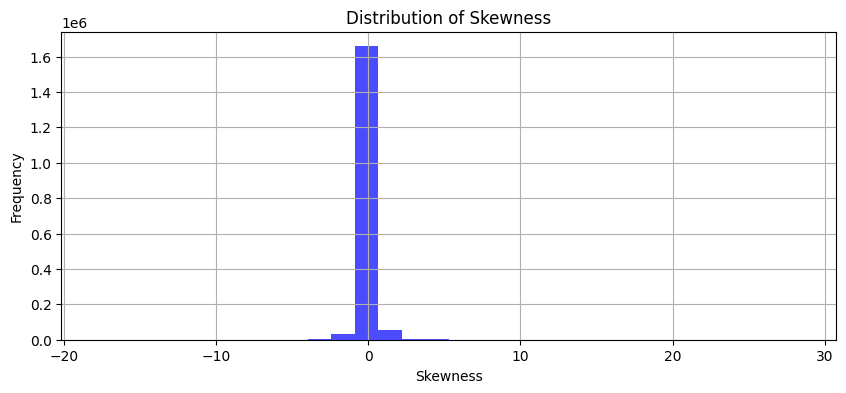

  Kurtosis: mean=3.5020, std=25.9547, min=-1.3901, max=903.9018


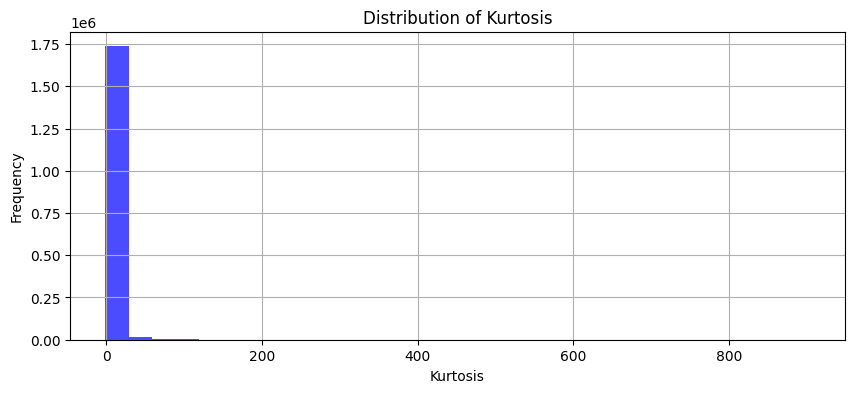

  Crest Factor: mean=7.6929, std=2.6439, min=3.4254, max=53.2001


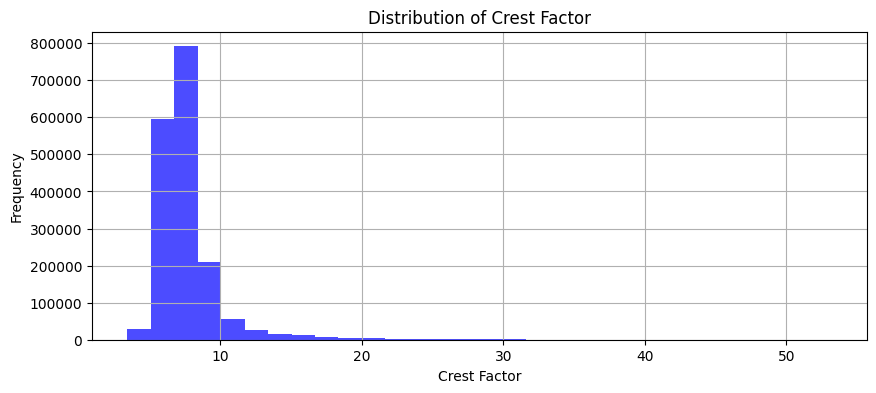

  Rolling SNR: mean=-0.4429, std=2.2883, min=-64.2152, max=2.6341


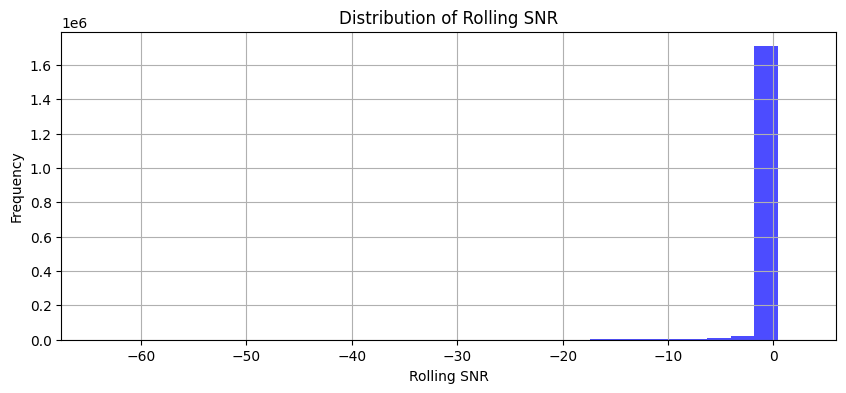

  Distortion: mean=0.0345, std=0.0504, min=0.0000, max=0.7529


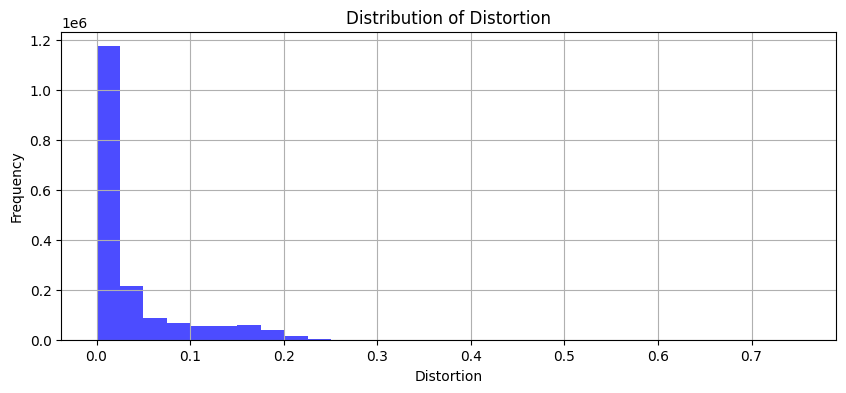

  Dominant Frequency: mean=0.3565, std=0.3214, min=0.0167, max=7.6833


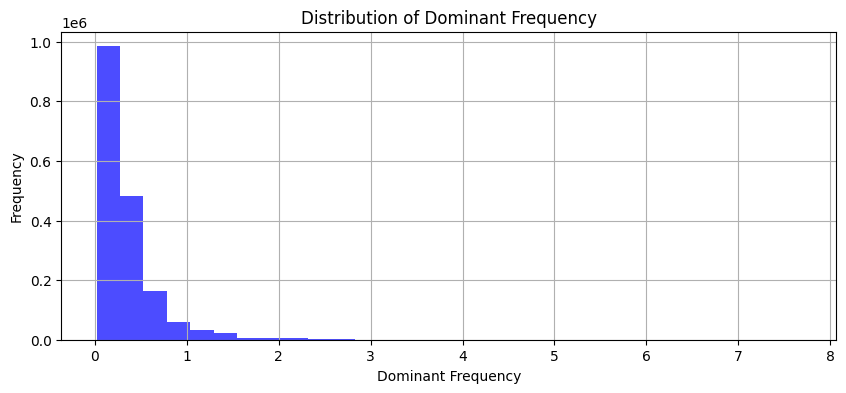

  Spectral Centroid: mean=4.4306, std=1.5308, min=0.6887, max=8.6788


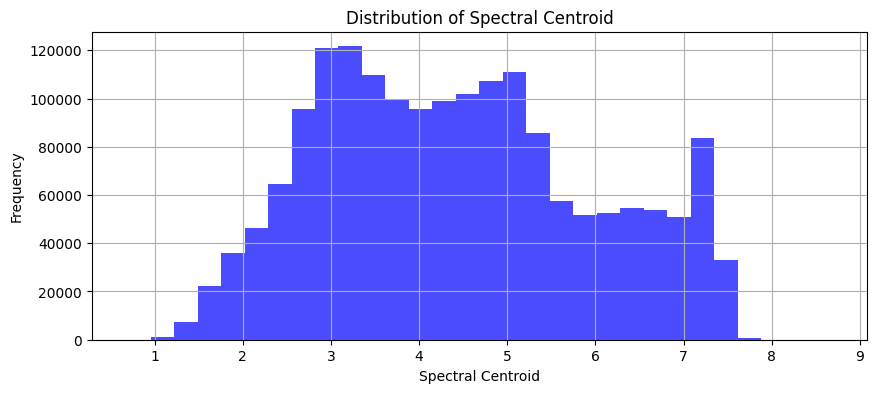

  Spectral Bandwidth: mean=6.0359, std=0.7170, min=1.2366, max=6.8100


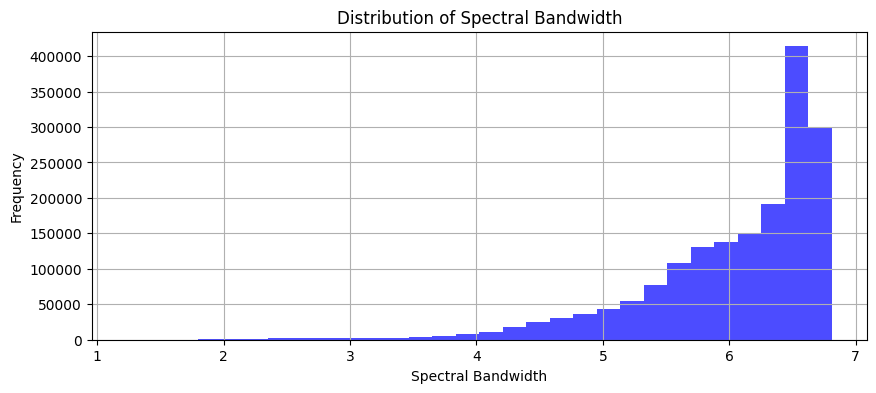

  Spectral Entropy: mean=8.7212, std=0.8275, min=5.0009, max=10.0333


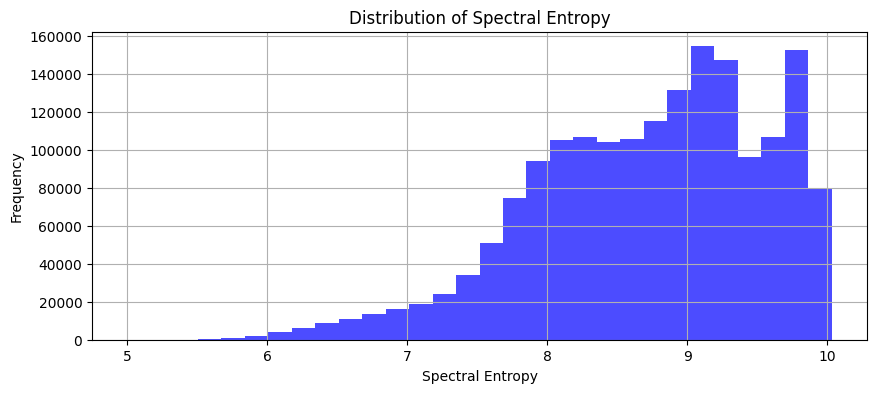

  Spectral Flatness: mean=0.3524, std=0.1440, min=0.0035, max=0.6602


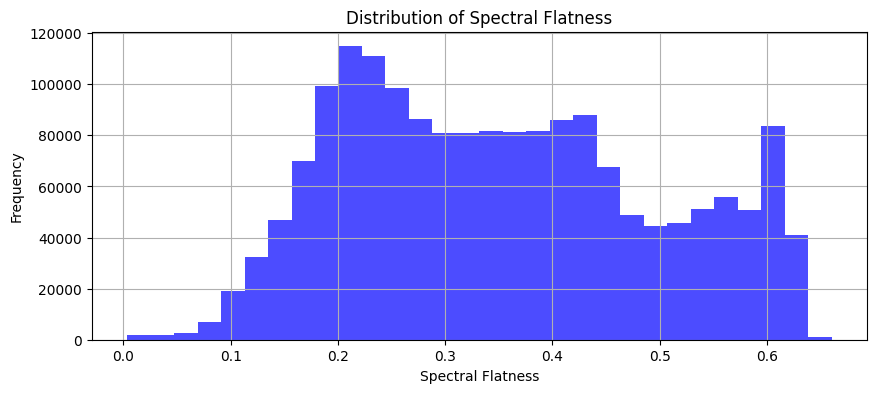

  Peak Frequency: mean=0.3565, std=0.3214, min=0.0167, max=7.6833


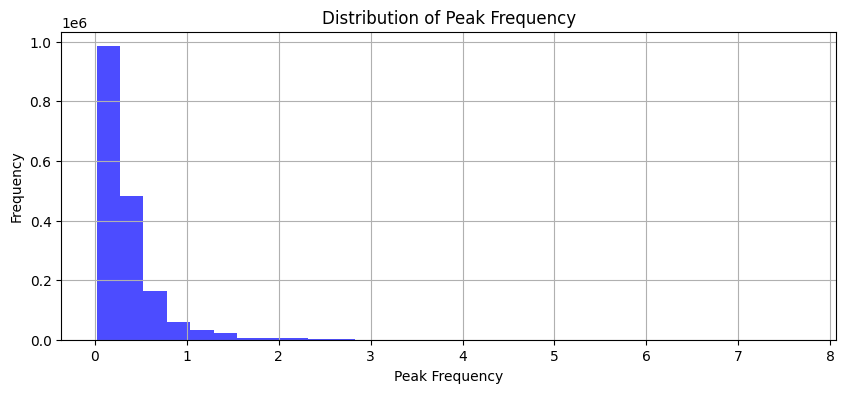

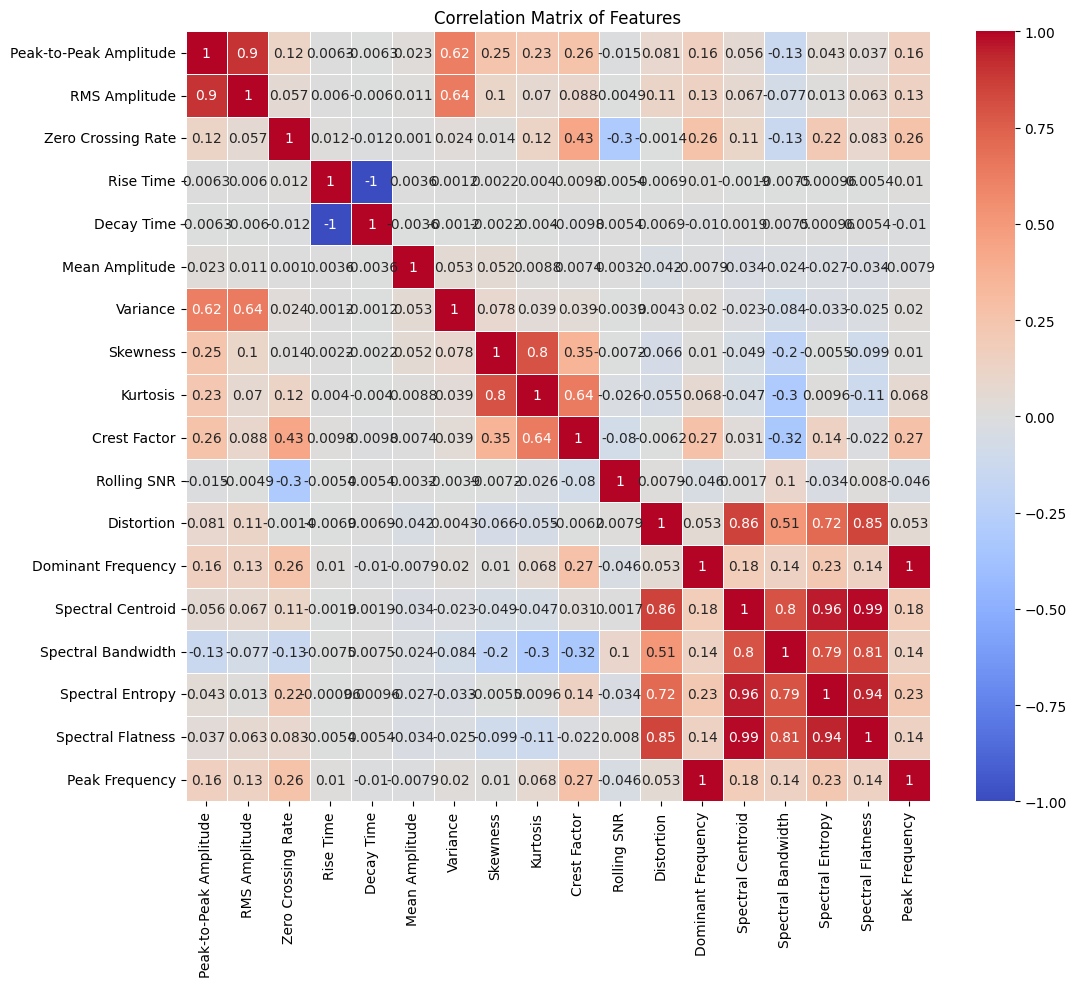

In [8]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def load_features(data_dir, stations):
    all_features = []
    for station in stations:
        feature_file = os.path.join(data_dir, f"{station}_features.pkl")
        if os.path.exists(feature_file):
            df = pd.read_pickle(feature_file)
            all_features.append(df)
            print(f"Loaded features for station {station}")
        else:
            print(f"Feature file for station {station} not found")
    if all_features:
        return pd.concat(all_features, ignore_index=True)
    else:
        return pd.DataFrame()

def check_feature_consistency(features_df):
    if features_df.empty:
        print("No features loaded to analyze.")
        return

    print("\nChecking features consistency")
    feature_keys = features_df.columns
    for key in feature_keys:
        if isinstance(features_df[key].iloc[0], dict):
            print(f"  {key}: complex feature (dict), skipping statistical analysis.")
            continue
        if features_df[key].isna().all():
            print(f"No values found for feature {key}")
            continue
        if pd.api.types.is_timedelta64_dtype(features_df[key]) or pd.api.types.is_datetime64_any_dtype(features_df[key]):
            print(f"  {key}: datetime feature, skipping statistical analysis.")
            continue
        mean_value = features_df[key].mean()
        std_value = features_df[key].std()
        min_value = features_df[key].min()
        max_value = features_df[key].max()
        print(f"  {key}: mean={mean_value:.4f}, std={std_value:.4f}, min={min_value:.4f}, max={max_value:.4f}")
        
        # Optional: Plot the distribution of the feature
        plt.figure(figsize=(10, 4))
        plt.hist(features_df[key].dropna(), bins=30, alpha=0.7, color='b')
        plt.title(f"Distribution of {key}")
        plt.xlabel(key)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

    # Plotting the correlation matrix
    numeric_features = features_df.select_dtypes(include=['float64', 'int64'])
    correlation_matrix = numeric_features.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Matrix of Features")
    plt.show()

if __name__ == "__main__":
    # Percorso principale delle stazioni
    data_dir = "output/infrasonic/"

    # Lista delle stazioni
    stations = ["ECPN", "ESLN", "EPDN", "ECNE"]
                
    # Caricamento delle feature
    all_features_df = load_features(data_dir, stations)

    # Controllo della coerenza delle feature
    check_feature_consistency(all_features_df)



In [9]:
import pandas as pd
import pickle

# Path to imputed pickle files
imputed_station_files = {
    'ECNE': 'output/ECNE_infrasonic_features.pkl',
    'ECPN': 'output/ECPN_infrasonic_features.pkl',
    'EPDN': 'output/EPDN_infrasonic_features.pkl',
    'ESLN': 'output/ESLN_infrasonic_features.pkl'
}

# Loading imputed data
imputed_dataframes = {}
for station, file_path in imputed_station_files.items():
    with open(file_path, 'rb') as file:
        imputed_dataframes[station] = pickle.load(file)

# Display summary of missing values for each station
for station, df in imputed_dataframes.items():
    print(f"Summary of missing values for {station}:")
    print(df.isna().sum())
    print("\n")

for station, df in imputed_dataframes.items():
    print(f"First 5 rows for {station}")
    print(df.head())
    print("\n")

Summary of missing values for ECNE:
index                          0
Peak-to-Peak Amplitude    522721
RMS Amplitude             522721
Zero Crossing Rate        522721
Rise Time                 522721
Decay Time                522721
Mean Amplitude            522721
Variance                  522721
Skewness                  522721
Kurtosis                  522721
Crest Factor              522721
Dominant Frequency        522721
Spectral Centroid         522721
Spectral Bandwidth        522721
Spectral Entropy          522721
Spectral Flatness         522721
Peak Frequency            522721
Rolling SNR               522721
dtype: int64


Summary of missing values for ECPN:
index                          0
Peak-to-Peak Amplitude    522721
RMS Amplitude             522721
Zero Crossing Rate        522721
Rise Time                 522721
Decay Time                522721
Mean Amplitude            522721
Variance                  522721
Skewness                  522721
Kurtosis              

In [2]:
# Updated code to handle "Timestamp" column as the index
import os
import pandas as pd
import pickle
from obspy.core.utcdatetime import UTCDateTime

# Function to convert UTCDateTime to datetime
def convert_timestamp(timestamp):
    if isinstance(timestamp, UTCDateTime):
        return timestamp.datetime
    return timestamp

# File paths
file_paths = ['output/infrasonic/ECNE_features.pkl', 'output/infrasonic/ECPN_features.pkl', 
              'output/infrasonic/EPDN_features.pkl', 'output/infrasonic/ESLN_features.pkl']

# Iterate through each file
for file_path in file_paths:
    # Get the station name
    station_name = os.path.basename(file_path).split('_')[0]

    # Load the DataFrame
    with open(file_path, 'rb') as file:
        df = pickle.load(file)

    # Set "Timestamp" column as the index and convert to datetime
    if 'Timestamp' in df.columns:
        df['Timestamp'] = df['Timestamp'].apply(convert_timestamp)
        df.set_index('Timestamp', inplace=True)
        df.index = pd.to_datetime(df.index)
    else:
        print(f"Il file {file_path} non ha una colonna 'Timestamp'.")
        continue

    # Create folder for the station
    station_folder = os.path.join('output/infrasonic/', station_name)
    os.makedirs(station_folder, exist_ok=True)

    # Save each feature as a separate .pkl file
    for column in df.columns:
        df_feature = df[[column]]
        df_feature.index.name = 'timestamp'

        # Output file path
        output_file_path = os.path.join(station_folder, f"{column}.pkl")

        # Save the DataFrame
        with open(output_file_path, 'wb') as output_file:
            pickle.dump(df_feature, output_file)

        print(f"Salvato {output_file_path} con {len(df_feature)} righe")




Salvato output/infrasonic/ECNE\Peak-to-Peak Amplitude.pkl con 525600 righe
Salvato output/infrasonic/ECNE\RMS Amplitude.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Zero Crossing Rate.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Rise Time.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Decay Time.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Mean Amplitude.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Variance.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Skewness.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Kurtosis.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Crest Factor.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Rolling SNR.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Distortion.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Dominant Frequency.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Spectral Centroid.pkl con 525600 righe
Salvato output/infrasonic/ECNE\Spectral Bandwidth.pkl con 525600 righe
Salvato o

In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
import os
import time

# Coordinate delle stazioni reali (latitudine, longitudine)
station_coords = {
    'ECNE': (37.7653, 15.0018),
    'ECPN': (37.7437, 14.9865),
    'EPDN': (37.7659, 15.0168),
    'ESLN': (37.6934, 14.9744),
}

# Percorso delle cartelle delle stazioni
station_dirs = {
    'ECNE': 'output/infrasonic/ECNE',
    'ECPN': 'output/infrasonic/ECPN',
    'EPDN': 'output/infrasonic/EPDN',
    'ESLN': 'output/infrasonic/ESLN'
}

# Lista delle feature da elaborare
features = ['Peak-to-Peak Amplitude', 'RMS Amplitude', 'Zero Crossing Rate', 'Rise Time', 'Decay Time', 'Mean Amplitude',
            'Variance', 'Skewness', 'Kurtosis', 'Crest Factor',
            'Dominant Frequency', 'Spectral Centroid', 'Spectral Bandwidth',
            'Spectral Entropy', 'Spectral Flatness', 'Peak Frequency','Rolling SNR']

# Calcola la matrice dei pesi in base alla distanza tra le stazioni
station_names = list(station_dirs.keys())
coords = np.radians([station_coords[station] for station in station_names])
distance_matrix = haversine_distances(coords, coords) * 6371  # Convert to kilometers and multiply by Earth's radius
np.fill_diagonal(distance_matrix, np.inf)  # Set self-distances to infinity to avoid division by zero
weight_matrix = 1 / distance_matrix

# Funzione per caricare i dati di una singola feature
def load_feature_data(feature_name, station_dirs):
    feature_data = {}
    for station, station_dir in station_dirs.items():
        # Percorso specifico per la singola feature
        feature_file = os.path.join(station_dir, f'{feature_name}.pkl').replace('\\', '/')
        if not os.path.exists(feature_file):
            raise FileNotFoundError(f"File non trovato: {feature_file}")
        # Leggi il file pickle
        data = pd.read_pickle(feature_file)
        # Verifica che il Timestamp sia l'indice
        if 'Timestamp' in data.columns:
            data['Timestamp'] = pd.to_datetime(data['Timestamp'])
            data.set_index('Timestamp', inplace=True)
        feature_data[station] = data.squeeze()  # Assicurati che sia una Serie
    return feature_data

# Imputazione dei dati mancanti utilizzando interpolazione lineare e media mobile ponderata
def weighted_moving_average_imputation(station_dirs, station_names, features, weight_matrix, window_size=3, gap_threshold='30T'):
    print("Caricamento dei timestamp in corso...")
    time.sleep(0.5)
    # Caricamento di tutti i timestamp
    all_timestamps = pd.Index(
        sorted(
            set().union(*[
                pd.read_pickle(os.path.join(station_dir, f'{features[0]}.pkl').replace('\\', '/')).index
                for station_dir in station_dirs.values()
            ])
        )
    )
    print("Timestamp caricati con successo.")

    for feature in features:
        print(f"Caricamento della feature '{feature}' in corso...")
        time.sleep(0.5)
        station_data = load_feature_data(feature, station_dirs)
        print(f"Feature '{feature}' caricata con successo.")

        # Allinea i timestamp per tutte le stazioni
        for station in station_names:
            station_data[station] = station_data[station].reindex(all_timestamps).fillna(np.nan)

        print(f"Eseguendo interpolazione lineare per la feature '{feature}'...")
        for station in station_names:
            gaps = station_data[station].isna()  # gaps come Serie
            gap_durations = gaps.groupby((~gaps).cumsum()).transform('size') * pd.Timedelta(minutes=1)
            station_data[station] = station_data[station].interpolate(
                method='time', limit_direction='both'
            ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
        print(f"Interpolazione lineare per la feature '{feature}' completata.")

        print(f"Inizio imputazione ponderata per la feature '{feature}'...")
        all_data = pd.concat(station_data, axis=1)
        all_data.columns = station_names

        for i in range(window_size, len(all_data)):
            if all_data.iloc[i].isna().any():
                for station in station_names:
                    if pd.isna(all_data.at[all_data.index[i], station]):
                        weighted_sum = 0
                        weight_total = 0
                        for j in range(1, window_size + 1):
                            if not pd.isna(all_data.iloc[i - j][station]):
                                weights = weight_matrix[station_names.index(station)]
                                weighted_sum += weights @ all_data.iloc[i - j].fillna(0)
                                weight_total += np.sum(weights)

                        if weight_total > 0:
                            all_data.at[all_data.index[i], station] = weighted_sum / weight_total

        print(f"Imputazione per la feature '{feature}' completata.")

        for station in station_names:
            output_dir = os.path.join(station_dirs[station] + '_imputed').replace('\\', '/')
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, f'{feature}_imputed.pkl').replace('\\', '/')
            with open(output_file, 'wb') as f:
                pickle.dump(all_data[station], f)
            print(f"Feature '{feature}' per la stazione '{station}' salvata con successo.")

# Applica l'imputazione ai dati delle stazioni
weighted_moving_average_imputation(station_dirs, station_names, features, weight_matrix)


Caricamento dei timestamp in corso...
Timestamp caricati con successo.
Caricamento della feature 'Peak-to-Peak Amplitude' in corso...
Feature 'Peak-to-Peak Amplitude' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Peak-to-Peak Amplitude'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Peak-to-Peak Amplitude' completata.
Inizio imputazione ponderata per la feature 'Peak-to-Peak Amplitude'...
Imputazione per la feature 'Peak-to-Peak Amplitude' completata.
Feature 'Peak-to-Peak Amplitude' per la stazione 'ECNE' salvata con successo.
Feature 'Peak-to-Peak Amplitude' per la stazione 'ECPN' salvata con successo.
Feature 'Peak-to-Peak Amplitude' per la stazione 'EPDN' salvata con successo.
Feature 'Peak-to-Peak Amplitude' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'RMS Amplitude' in corso...
Feature 'RMS Amplitude' caricata con successo.
Eseguendo interpolazione lineare per la feature 'RMS Amplitude'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'RMS Amplitude' completata.
Inizio imputazione ponderata per la feature 'RMS Amplitude'...
Imputazione per la feature 'RMS Amplitude' completata.
Feature 'RMS Amplitude' per la stazione 'ECNE' salvata con successo.
Feature 'RMS Amplitude' per la stazione 'ECPN' salvata con successo.
Feature 'RMS Amplitude' per la stazione 'EPDN' salvata con successo.
Feature 'RMS Amplitude' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Zero Crossing Rate' in corso...
Feature 'Zero Crossing Rate' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Zero Crossing Rate'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Zero Crossing Rate' completata.
Inizio imputazione ponderata per la feature 'Zero Crossing Rate'...
Imputazione per la feature 'Zero Crossing Rate' completata.
Feature 'Zero Crossing Rate' per la stazione 'ECNE' salvata con successo.
Feature 'Zero Crossing Rate' per la stazione 'ECPN' salvata con successo.
Feature 'Zero Crossing Rate' per la stazione 'EPDN' salvata con successo.
Feature 'Zero Crossing Rate' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Rise Time' in corso...
Feature 'Rise Time' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Rise Time'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Rise Time' completata.
Inizio imputazione ponderata per la feature 'Rise Time'...
Imputazione per la feature 'Rise Time' completata.
Feature 'Rise Time' per la stazione 'ECNE' salvata con successo.
Feature 'Rise Time' per la stazione 'ECPN' salvata con successo.
Feature 'Rise Time' per la stazione 'EPDN' salvata con successo.
Feature 'Rise Time' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Decay Time' in corso...
Feature 'Decay Time' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Decay Time'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Decay Time' completata.
Inizio imputazione ponderata per la feature 'Decay Time'...
Imputazione per la feature 'Decay Time' completata.
Feature 'Decay Time' per la stazione 'ECNE' salvata con successo.
Feature 'Decay Time' per la stazione 'ECPN' salvata con successo.
Feature 'Decay Time' per la stazione 'EPDN' salvata con successo.
Feature 'Decay Time' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Mean Amplitude' in corso...
Feature 'Mean Amplitude' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Mean Amplitude'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Mean Amplitude' completata.
Inizio imputazione ponderata per la feature 'Mean Amplitude'...
Imputazione per la feature 'Mean Amplitude' completata.
Feature 'Mean Amplitude' per la stazione 'ECNE' salvata con successo.
Feature 'Mean Amplitude' per la stazione 'ECPN' salvata con successo.
Feature 'Mean Amplitude' per la stazione 'EPDN' salvata con successo.
Feature 'Mean Amplitude' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Variance' in corso...
Feature 'Variance' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Variance'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Variance' completata.
Inizio imputazione ponderata per la feature 'Variance'...
Imputazione per la feature 'Variance' completata.
Feature 'Variance' per la stazione 'ECNE' salvata con successo.
Feature 'Variance' per la stazione 'ECPN' salvata con successo.
Feature 'Variance' per la stazione 'EPDN' salvata con successo.
Feature 'Variance' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Skewness' in corso...
Feature 'Skewness' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Skewness'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Skewness' completata.
Inizio imputazione ponderata per la feature 'Skewness'...
Imputazione per la feature 'Skewness' completata.
Feature 'Skewness' per la stazione 'ECNE' salvata con successo.
Feature 'Skewness' per la stazione 'ECPN' salvata con successo.
Feature 'Skewness' per la stazione 'EPDN' salvata con successo.
Feature 'Skewness' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Kurtosis' in corso...
Feature 'Kurtosis' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Kurtosis'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Kurtosis' completata.
Inizio imputazione ponderata per la feature 'Kurtosis'...
Imputazione per la feature 'Kurtosis' completata.
Feature 'Kurtosis' per la stazione 'ECNE' salvata con successo.
Feature 'Kurtosis' per la stazione 'ECPN' salvata con successo.
Feature 'Kurtosis' per la stazione 'EPDN' salvata con successo.
Feature 'Kurtosis' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Crest Factor' in corso...
Feature 'Crest Factor' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Crest Factor'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Crest Factor' completata.
Inizio imputazione ponderata per la feature 'Crest Factor'...
Imputazione per la feature 'Crest Factor' completata.
Feature 'Crest Factor' per la stazione 'ECNE' salvata con successo.
Feature 'Crest Factor' per la stazione 'ECPN' salvata con successo.
Feature 'Crest Factor' per la stazione 'EPDN' salvata con successo.
Feature 'Crest Factor' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Dominant Frequency' in corso...
Feature 'Dominant Frequency' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Dominant Frequency'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Dominant Frequency' completata.
Inizio imputazione ponderata per la feature 'Dominant Frequency'...
Imputazione per la feature 'Dominant Frequency' completata.
Feature 'Dominant Frequency' per la stazione 'ECNE' salvata con successo.
Feature 'Dominant Frequency' per la stazione 'ECPN' salvata con successo.
Feature 'Dominant Frequency' per la stazione 'EPDN' salvata con successo.
Feature 'Dominant Frequency' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Spectral Centroid' in corso...
Feature 'Spectral Centroid' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Spectral Centroid'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Spectral Centroid' completata.
Inizio imputazione ponderata per la feature 'Spectral Centroid'...
Imputazione per la feature 'Spectral Centroid' completata.
Feature 'Spectral Centroid' per la stazione 'ECNE' salvata con successo.
Feature 'Spectral Centroid' per la stazione 'ECPN' salvata con successo.
Feature 'Spectral Centroid' per la stazione 'EPDN' salvata con successo.
Feature 'Spectral Centroid' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Spectral Bandwidth' in corso...
Feature 'Spectral Bandwidth' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Spectral Bandwidth'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Spectral Bandwidth' completata.
Inizio imputazione ponderata per la feature 'Spectral Bandwidth'...
Imputazione per la feature 'Spectral Bandwidth' completata.
Feature 'Spectral Bandwidth' per la stazione 'ECNE' salvata con successo.
Feature 'Spectral Bandwidth' per la stazione 'ECPN' salvata con successo.
Feature 'Spectral Bandwidth' per la stazione 'EPDN' salvata con successo.
Feature 'Spectral Bandwidth' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Spectral Entropy' in corso...
Feature 'Spectral Entropy' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Spectral Entropy'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Spectral Entropy' completata.
Inizio imputazione ponderata per la feature 'Spectral Entropy'...
Imputazione per la feature 'Spectral Entropy' completata.
Feature 'Spectral Entropy' per la stazione 'ECNE' salvata con successo.
Feature 'Spectral Entropy' per la stazione 'ECPN' salvata con successo.
Feature 'Spectral Entropy' per la stazione 'EPDN' salvata con successo.
Feature 'Spectral Entropy' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Spectral Flatness' in corso...
Feature 'Spectral Flatness' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Spectral Flatness'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Spectral Flatness' completata.
Inizio imputazione ponderata per la feature 'Spectral Flatness'...
Imputazione per la feature 'Spectral Flatness' completata.
Feature 'Spectral Flatness' per la stazione 'ECNE' salvata con successo.
Feature 'Spectral Flatness' per la stazione 'ECPN' salvata con successo.
Feature 'Spectral Flatness' per la stazione 'EPDN' salvata con successo.
Feature 'Spectral Flatness' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Peak Frequency' in corso...
Feature 'Peak Frequency' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Peak Frequency'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Peak Frequency' completata.
Inizio imputazione ponderata per la feature 'Peak Frequency'...
Imputazione per la feature 'Peak Frequency' completata.
Feature 'Peak Frequency' per la stazione 'ECNE' salvata con successo.
Feature 'Peak Frequency' per la stazione 'ECPN' salvata con successo.
Feature 'Peak Frequency' per la stazione 'EPDN' salvata con successo.
Feature 'Peak Frequency' per la stazione 'ESLN' salvata con successo.
Caricamento della feature 'Rolling SNR' in corso...
Feature 'Rolling SNR' caricata con successo.
Eseguendo interpolazione lineare per la feature 'Rolling SNR'...


C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_data[station])
C:\Users\giuli\AppData\Local\Temp\ipykernel_17132\314788175.py:85: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  ).where(gap_durations <= pd.Timedelta(gap_threshold), station_dat

Interpolazione lineare per la feature 'Rolling SNR' completata.
Inizio imputazione ponderata per la feature 'Rolling SNR'...
Imputazione per la feature 'Rolling SNR' completata.
Feature 'Rolling SNR' per la stazione 'ECNE' salvata con successo.
Feature 'Rolling SNR' per la stazione 'ECPN' salvata con successo.
Feature 'Rolling SNR' per la stazione 'EPDN' salvata con successo.
Feature 'Rolling SNR' per la stazione 'ESLN' salvata con successo.


In [4]:
import pandas as pd
import numpy as np
import os

# Funzione per rilevare e rimpiazzare outlier utilizzando il metodo Z-Score
def replace_outliers_zscore(data, threshold=3):
    """
    Rimpiazza gli outlier in una Serie basandosi sullo Z-Score.

    Parameters:
        data (pd.Series): Serie con i dati.
        threshold (float): Soglia per lo Z-Score oltre cui un valore viene considerato un outlier.

    Returns:
        tuple: Serie con outlier rimpiazzati tramite interpolazione, numero di outlier rimpiazzati.
    """
    mean = data.mean()
    std = data.std()

    z_scores = (data - mean) / std
    outliers = np.abs(z_scores) > threshold

    # Interpola i valori outlier
    data[outliers] = np.nan
    data = data.interpolate(method='linear', limit_direction='both')

    return data, outliers.sum()

# Funzione per processare i file pickle delle feature

def process_feature_files(input_dirs, output_dirs, feature_list, threshold=3):
    """
    Rimpiazza gli outlier da ogni file di feature e salva i file processati.

    Parameters:
        input_dirs (dict): Dizionario con stazioni come chiavi e percorsi di input come valori.
        output_dirs (dict): Dizionario con stazioni come chiavi e percorsi di output come valori.
        feature_list (list): Lista delle feature da processare.
        threshold (float): Soglia per lo Z-Score oltre cui un valore viene considerato un outlier.
    """
    for station, input_dir in input_dirs.items():
        output_dir = output_dirs[station]
        os.makedirs(output_dir, exist_ok=True)

        for feature in feature_list:
            input_file = os.path.join(input_dir, f"{feature}_imputed.pkl").replace('\\', '/')
            if not os.path.exists(input_file):
                print(f"File non trovato: {input_file}")
                continue

            # Carica il file pickle
            data = pd.read_pickle(input_file)

            # Rimpiazza gli outlier
            if isinstance(data, pd.Series):
                data_cleaned, outliers_count = replace_outliers_zscore(data, threshold)

                # Salva il file processato
                output_file = os.path.join(output_dir, f"{feature}_cleaned.pkl").replace('\\', '/')
                data_cleaned.to_pickle(output_file)
                print(f"Outlier rimpiazzati per la feature '{feature}' nella stazione '{station}': {outliers_count} outlier rimpiazzati. File salvato in: {output_file}")
            else:
                print(f"Dati non validi per la feature '{feature}' nella stazione '{station}'. Atteso: pd.Series, trovato: {type(data)}")

# Esempio di utilizzo
station_dirs = {
    'ECNE': 'output/infrasonic/ECNE_imputed',
    'ECPN': 'output/infrasonic/ECPN_imputed',
    'EPDN': 'output/infrasonic/EPDN_imputed',
    'ESLN': 'output/infrasonic/ESLN_imputed'
}

output_dirs = {
    'ECNE': 'output/infrasonic_cleaned/ECNE',
    'ECPN': 'output/infrasonic_cleaned/ECPN',
    'EPDN': 'output/infrasonic_cleaned/EPDN',
    'ESLN': 'output/infrasonic_cleaned/ESLN'
}

features = ['Peak-to-Peak Amplitude', 'RMS Amplitude', 'Zero Crossing Rate', 'Rise Time', 'Decay Time',
            'Mean Amplitude', 'Variance', 'Skewness', 'Kurtosis', 'Crest Factor',
            'Dominant Frequency', 'Spectral Centroid', 'Spectral Bandwidth',
            'Spectral Entropy', 'Spectral Flatness', 'Peak Frequency', 'Rolling SNR']

process_feature_files(station_dirs, output_dirs, features)



Outlier rimpiazzati per la feature 'Peak-to-Peak Amplitude' nella stazione 'ECNE': 4977 outlier rimpiazzati. File salvato in: output/infrasonic_cleaned/ECNE/Peak-to-Peak Amplitude_cleaned.pkl
Outlier rimpiazzati per la feature 'RMS Amplitude' nella stazione 'ECNE': 5052 outlier rimpiazzati. File salvato in: output/infrasonic_cleaned/ECNE/RMS Amplitude_cleaned.pkl
Outlier rimpiazzati per la feature 'Zero Crossing Rate' nella stazione 'ECNE': 8242 outlier rimpiazzati. File salvato in: output/infrasonic_cleaned/ECNE/Zero Crossing Rate_cleaned.pkl
Outlier rimpiazzati per la feature 'Rise Time' nella stazione 'ECNE': 0 outlier rimpiazzati. File salvato in: output/infrasonic_cleaned/ECNE/Rise Time_cleaned.pkl
Outlier rimpiazzati per la feature 'Decay Time' nella stazione 'ECNE': 0 outlier rimpiazzati. File salvato in: output/infrasonic_cleaned/ECNE/Decay Time_cleaned.pkl
Outlier rimpiazzati per la feature 'Mean Amplitude' nella stazione 'ECNE': 557 outlier rimpiazzati. File salvato in: outpu

Caricamento e plot della feature 'Peak-to-Peak Amplitude' in corso...


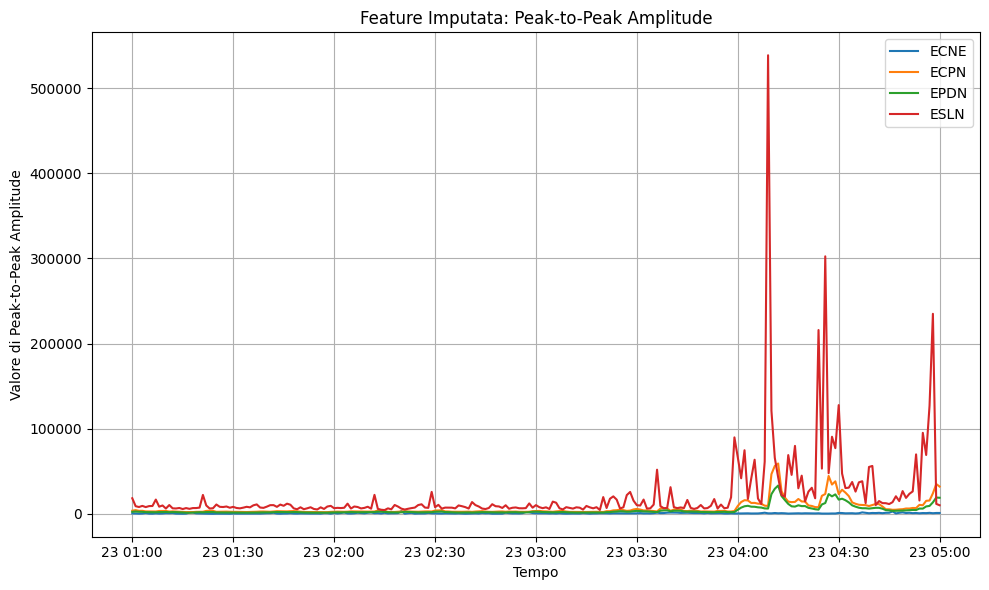

Caricamento e plot della feature 'RMS Amplitude' in corso...


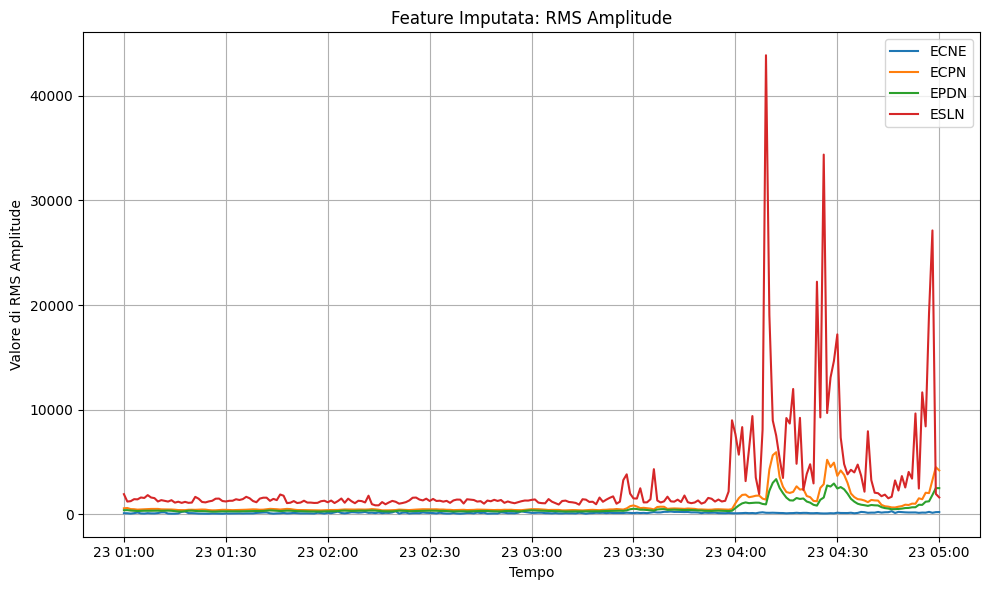

Caricamento e plot della feature 'Zero Crossing Rate' in corso...


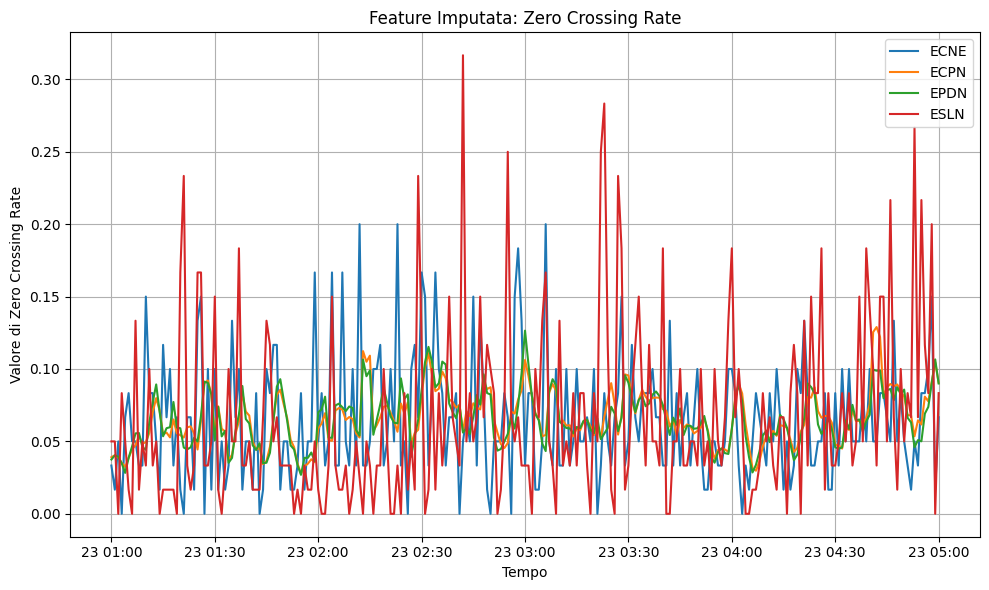

Caricamento e plot della feature 'Rise Time' in corso...


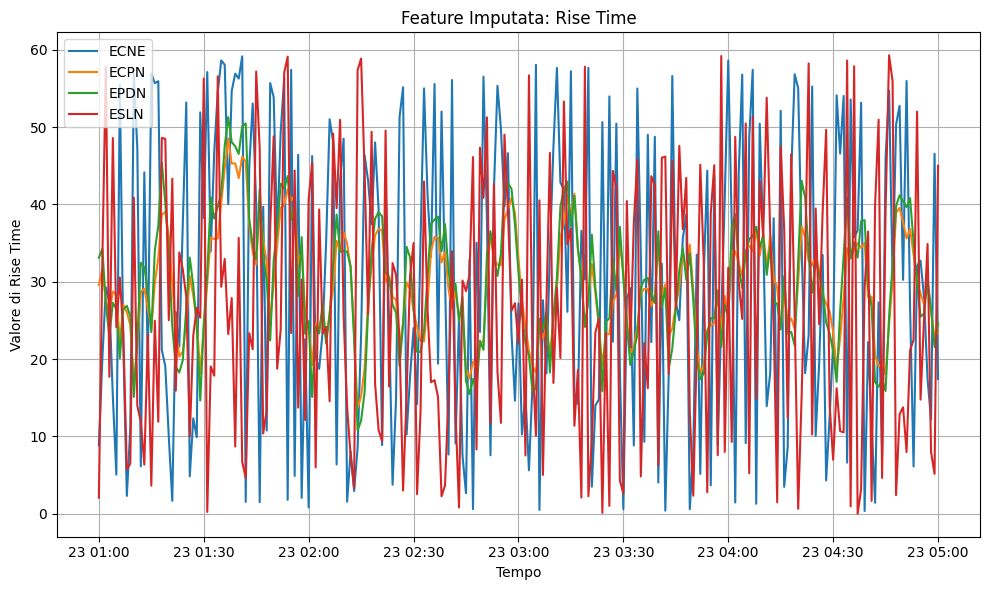

Caricamento e plot della feature 'Decay Time' in corso...


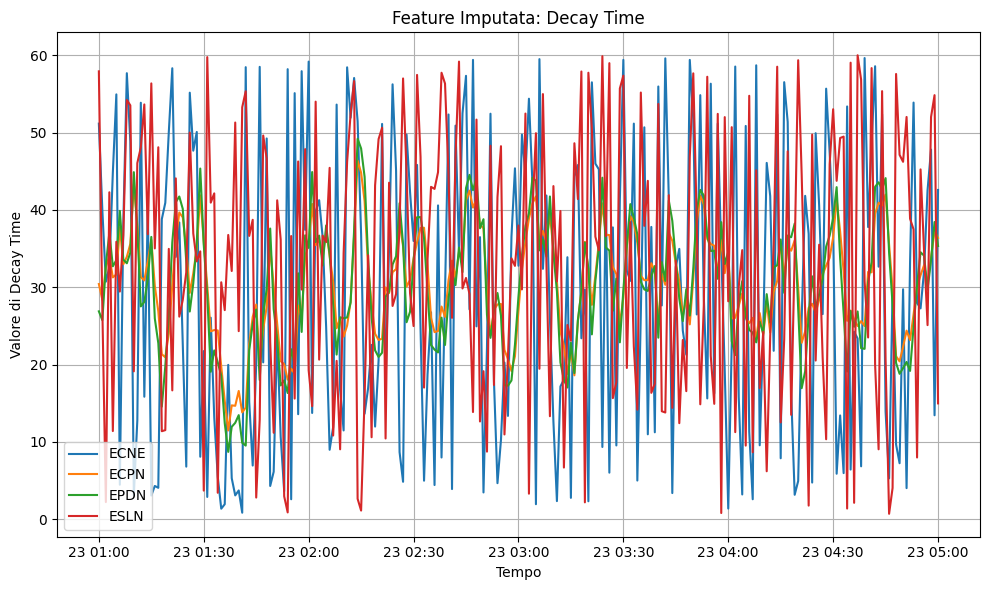

Caricamento e plot della feature 'Mean Amplitude' in corso...


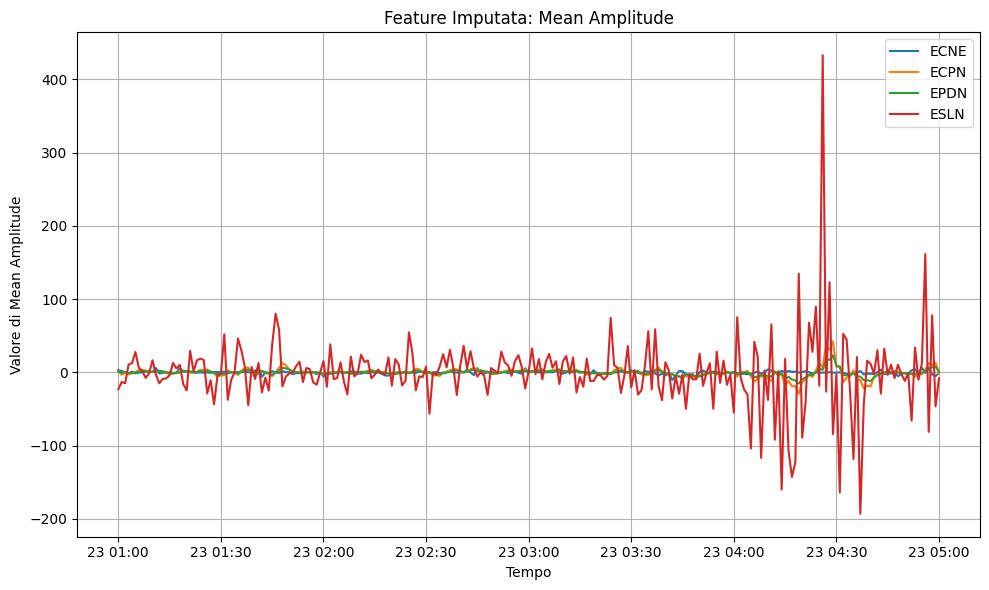

Caricamento e plot della feature 'Variance' in corso...


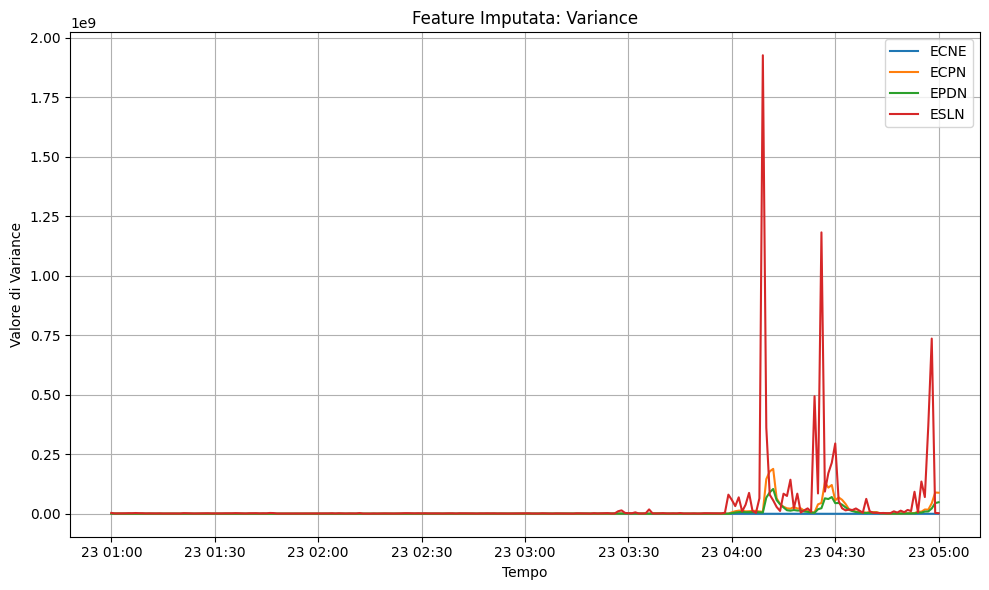

Caricamento e plot della feature 'Skewness' in corso...


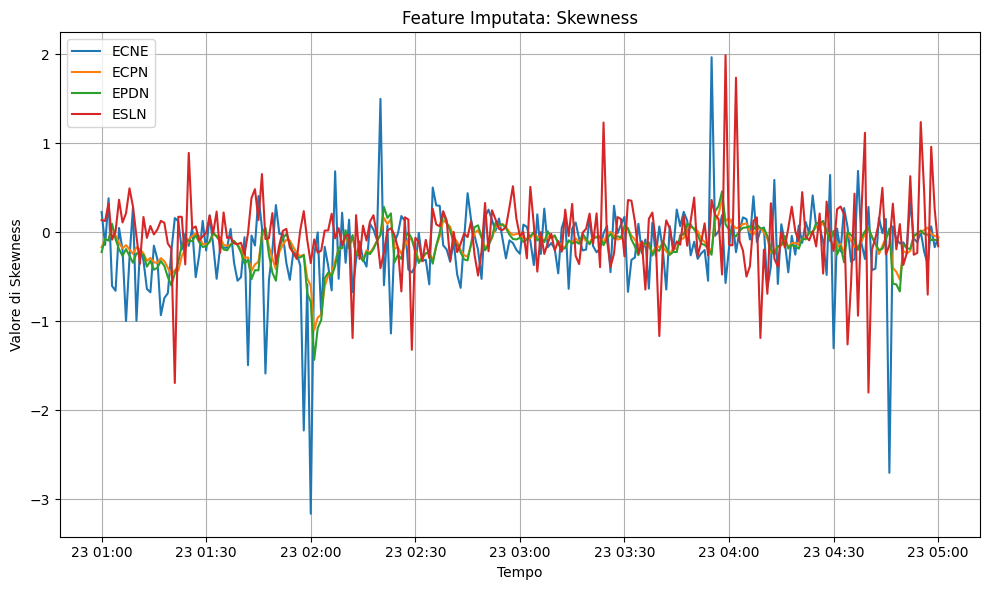

Caricamento e plot della feature 'Kurtosis' in corso...


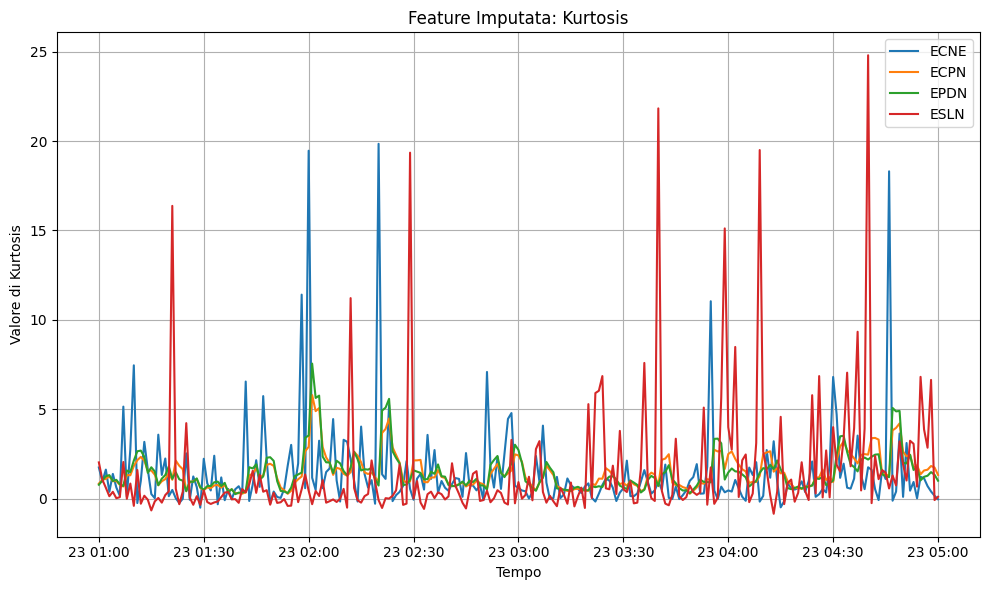

Caricamento e plot della feature 'Crest Factor' in corso...


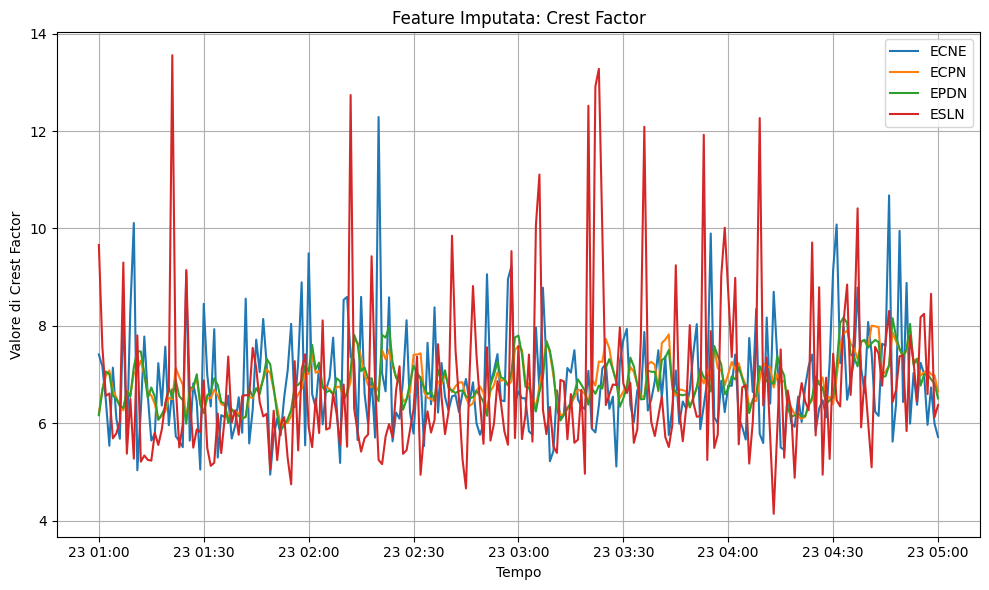

Caricamento e plot della feature 'Dominant Frequency' in corso...


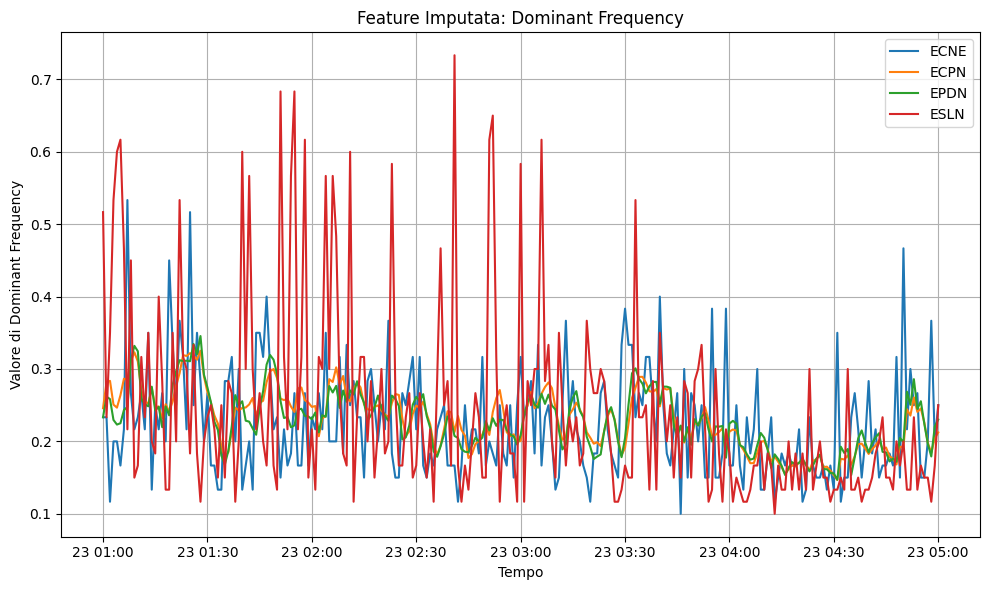

Caricamento e plot della feature 'Spectral Centroid' in corso...


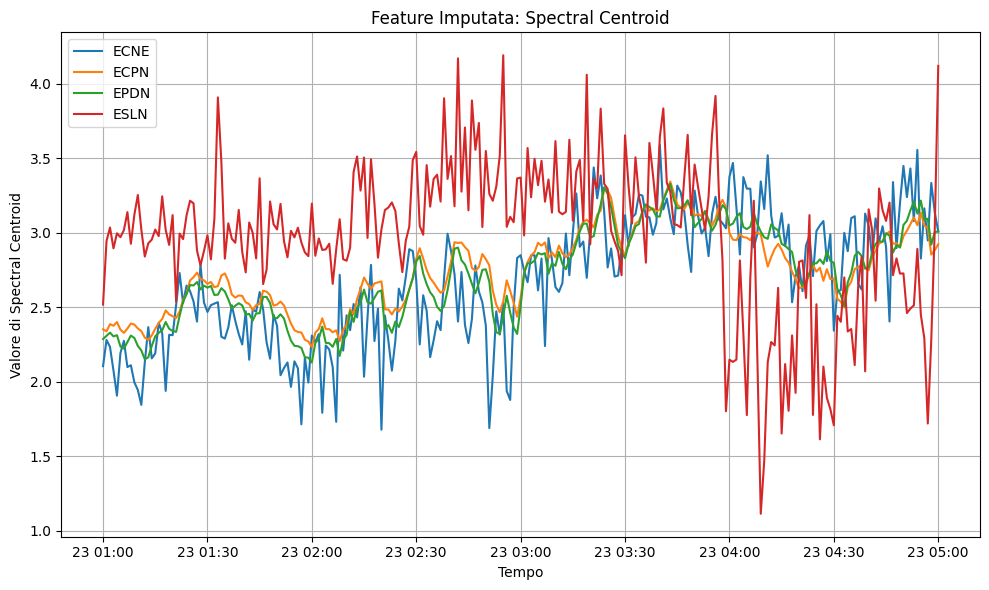

Caricamento e plot della feature 'Spectral Bandwidth' in corso...


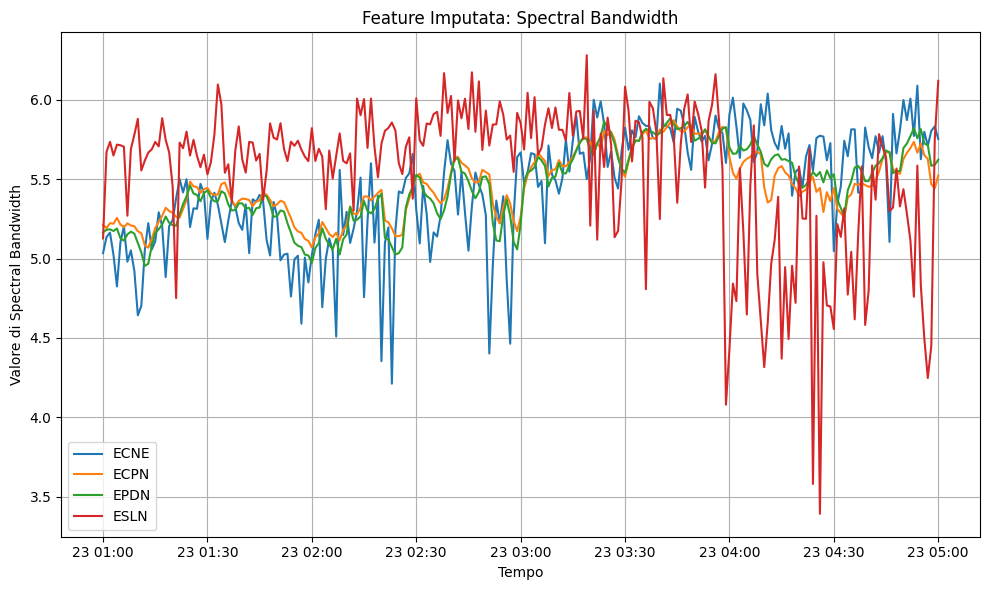

Caricamento e plot della feature 'Spectral Entropy' in corso...


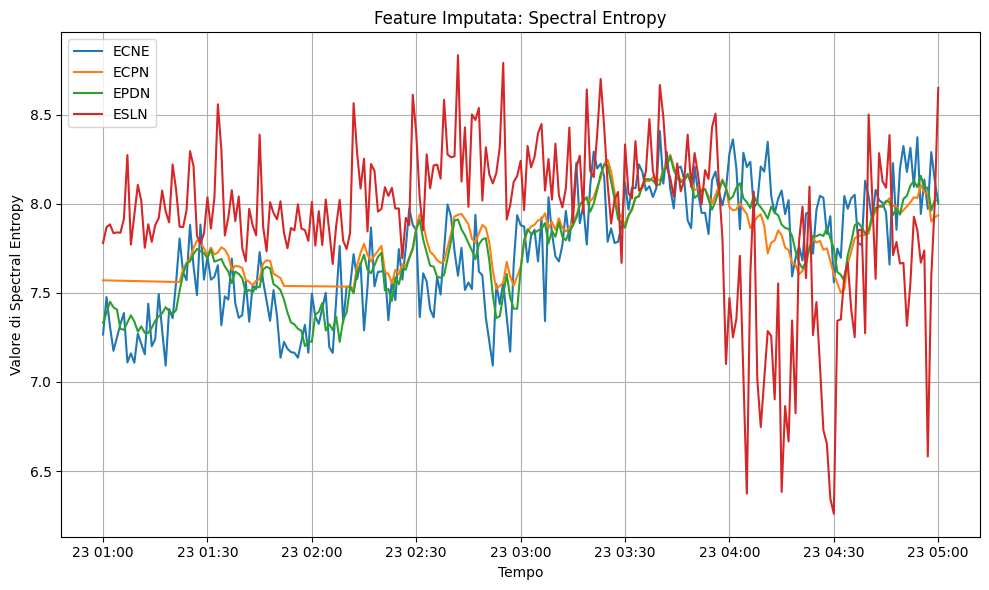

Caricamento e plot della feature 'Spectral Flatness' in corso...


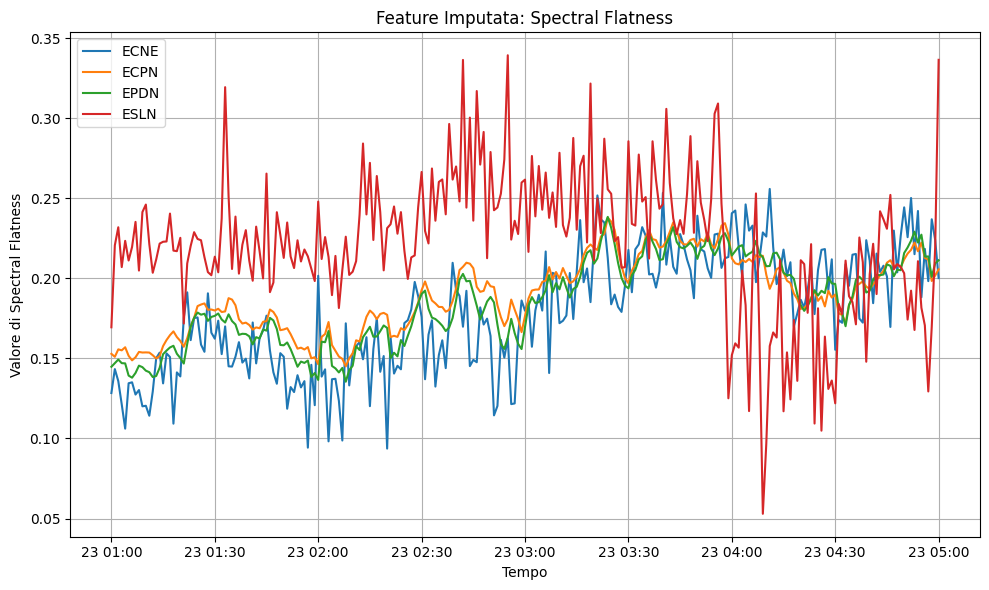

Caricamento e plot della feature 'Peak Frequency' in corso...


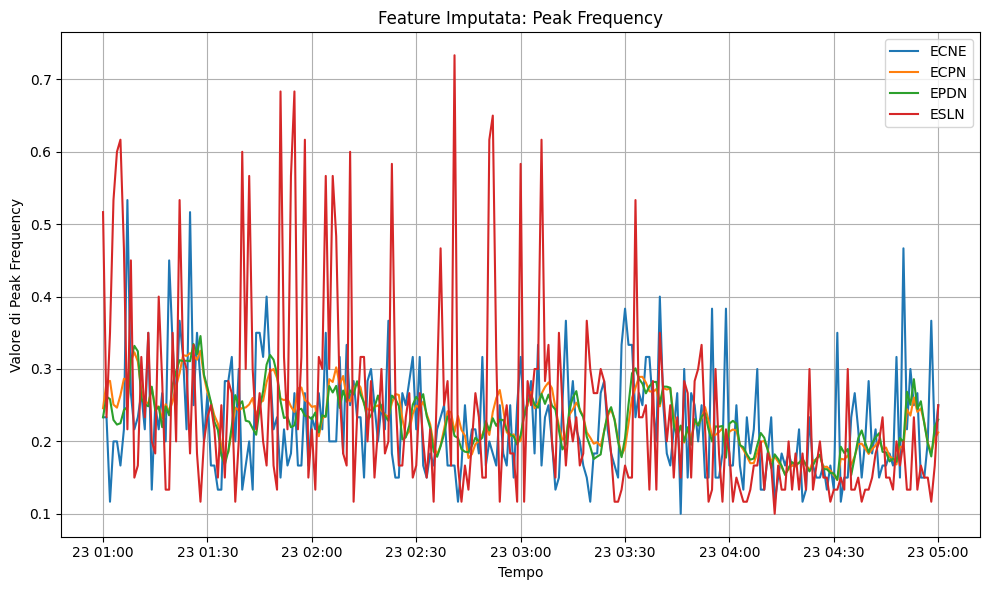

Caricamento e plot della feature 'Rolling SNR' in corso...


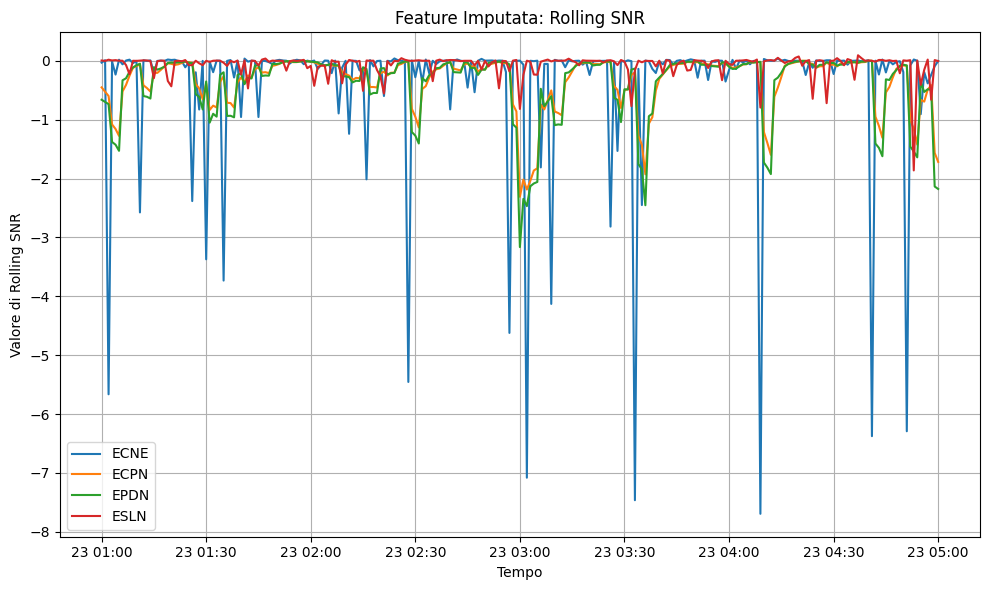

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os


station_dirs = {
    'ECNE': 'output/infrasonic_cleaned/ECNE',
    'ECPN': 'output/infrasonic_cleaned/ECPN',
    'EPDN': 'output/infrasonic_cleaned/EPDN',
    'ESLN': 'output/infrasonic_cleaned/ESLN'
}

# Lista delle feature da elaborare
features = ['Peak-to-Peak Amplitude', 'RMS Amplitude', 'Zero Crossing Rate', 'Rise Time', 'Decay Time', 'Mean Amplitude',
            'Variance', 'Skewness', 'Kurtosis', 'Crest Factor',
            'Dominant Frequency', 'Spectral Centroid', 'Spectral Bandwidth',
            'Spectral Entropy', 'Spectral Flatness', 'Peak Frequency', 'Rolling SNR']

# Funzione per caricare i dati imputati
def load_imputed_feature_data(feature_name, station_dirs):
    feature_data = {}
    for station, station_dir in station_dirs.items():
        feature_file = os.path.join(station_dir, f'{feature_name}_cleaned.pkl')
        with open(feature_file, 'rb') as f:
            data = pickle.load(f)
            feature_data[station] = data
    return feature_data

# Funzione per plottare i dati in un arco temporale specifico
def plot_imputed_features(features, station_dirs, start_time=None, end_time=None):
    for feature in features:
        print(f"Caricamento e plot della feature '{feature}' in corso...")
        feature_data = load_imputed_feature_data(feature, station_dirs)
        plt.figure(figsize=(10, 6))

        for station, data in feature_data.items():
            if start_time and end_time:
                data = data[(data.index >= start_time) & (data.index <= end_time)]
            plt.plot(data.index, data.values, label=station)

        plt.title(f"Feature Imputata: {feature}")
        plt.xlabel("Tempo")
        plt.ylabel(f"Valore di {feature}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Plottaggio dei dati imputati in un arco temporale specificato
tempo_inizio = '2021-3-23 1:00:00'
tempo_fine = '2021-3-23 5:00:00'

plot_imputed_features(features, station_dirs, start_time=tempo_inizio, end_time=tempo_fine)
